<a href="https://colab.research.google.com/github/CodeHunterOfficial/AI_DataMining/blob/main/NLP/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8_%C2%AB%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D0%BA_%D0%BF%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D0%B8%C2%BB_(seq2seq)_%D0%B8_%D0%B2%D0%BD%D0%B8%D0%BC%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Модели «последовательность к последовательности» (seq2seq) и внимание**

Одной из самых популярных задач преобразования последовательностей является машинный перевод, обычно между двумя естественными языками. За последние несколько лет коммерческие системы значительно улучшились, и машинный перевод стал удивительно точным. Примером таких систем являются Google Translate, Yandex Translate, DeepL и Bing Microsoft Translator. Сегодня мы рассмотрим основные компоненты этих систем.


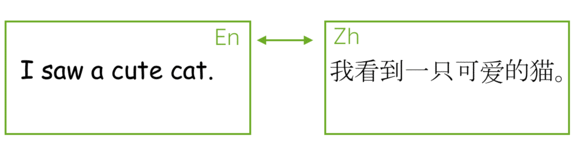


Хотя перевод между естественными языками наиболее известен, модели seq2seq также могут использоваться для преобразования между языками программирования (например, в работе Facebook AI по использованию глубокого обучения для перевода кода) или для преобразования любых последовательностей токенов. Отныне под «машинным переводом» мы будем понимать любую задачу преобразования последовательностей, то есть преобразование одной последовательности токенов в другую, независимо от их природы.

В следующих разделах мы сначала познакомимся с основами моделей seq2seq, затем рассмотрим концепцию внимания — ключевого элемента современных систем — и, наконец, изучим популярную модель Transformer. В процессе мы будем приводить много анализов, упражнений, статей и веселья!



**Основы моделей «последовательность к последовательности»**

Формально, в задаче машинного перевода у нас есть входная последовательность $x_1, x_2, \dots, x_m$ и выходная последовательность $y_1, y_2, \dots, y_n$, где $m$ и $n$ могут быть разной длины. Цель перевода — найти наиболее вероятную целевую последовательность, заданную входными данными. Математически это означает, что мы ищем целевую последовательность, которая максимизирует условную вероятность $p(y | x)$, где:

$$
y^* = \arg\max_y p(y | x)
$$

Если вы двуязычны и можете легко переводить между языками, вы, вероятно, интуитивно понимаете $p(y | x)$. Вы могли бы сказать что-то вроде: «Этот перевод звучит более естественно для этого предложения». В машинном переводе, однако, мы обучаем функцию $p(y | x, \theta)$, где $\theta$ — это параметры модели, а затем находим argmax для заданного входа:

$$
y' = \arg\max_y p(y | x, \theta)
$$



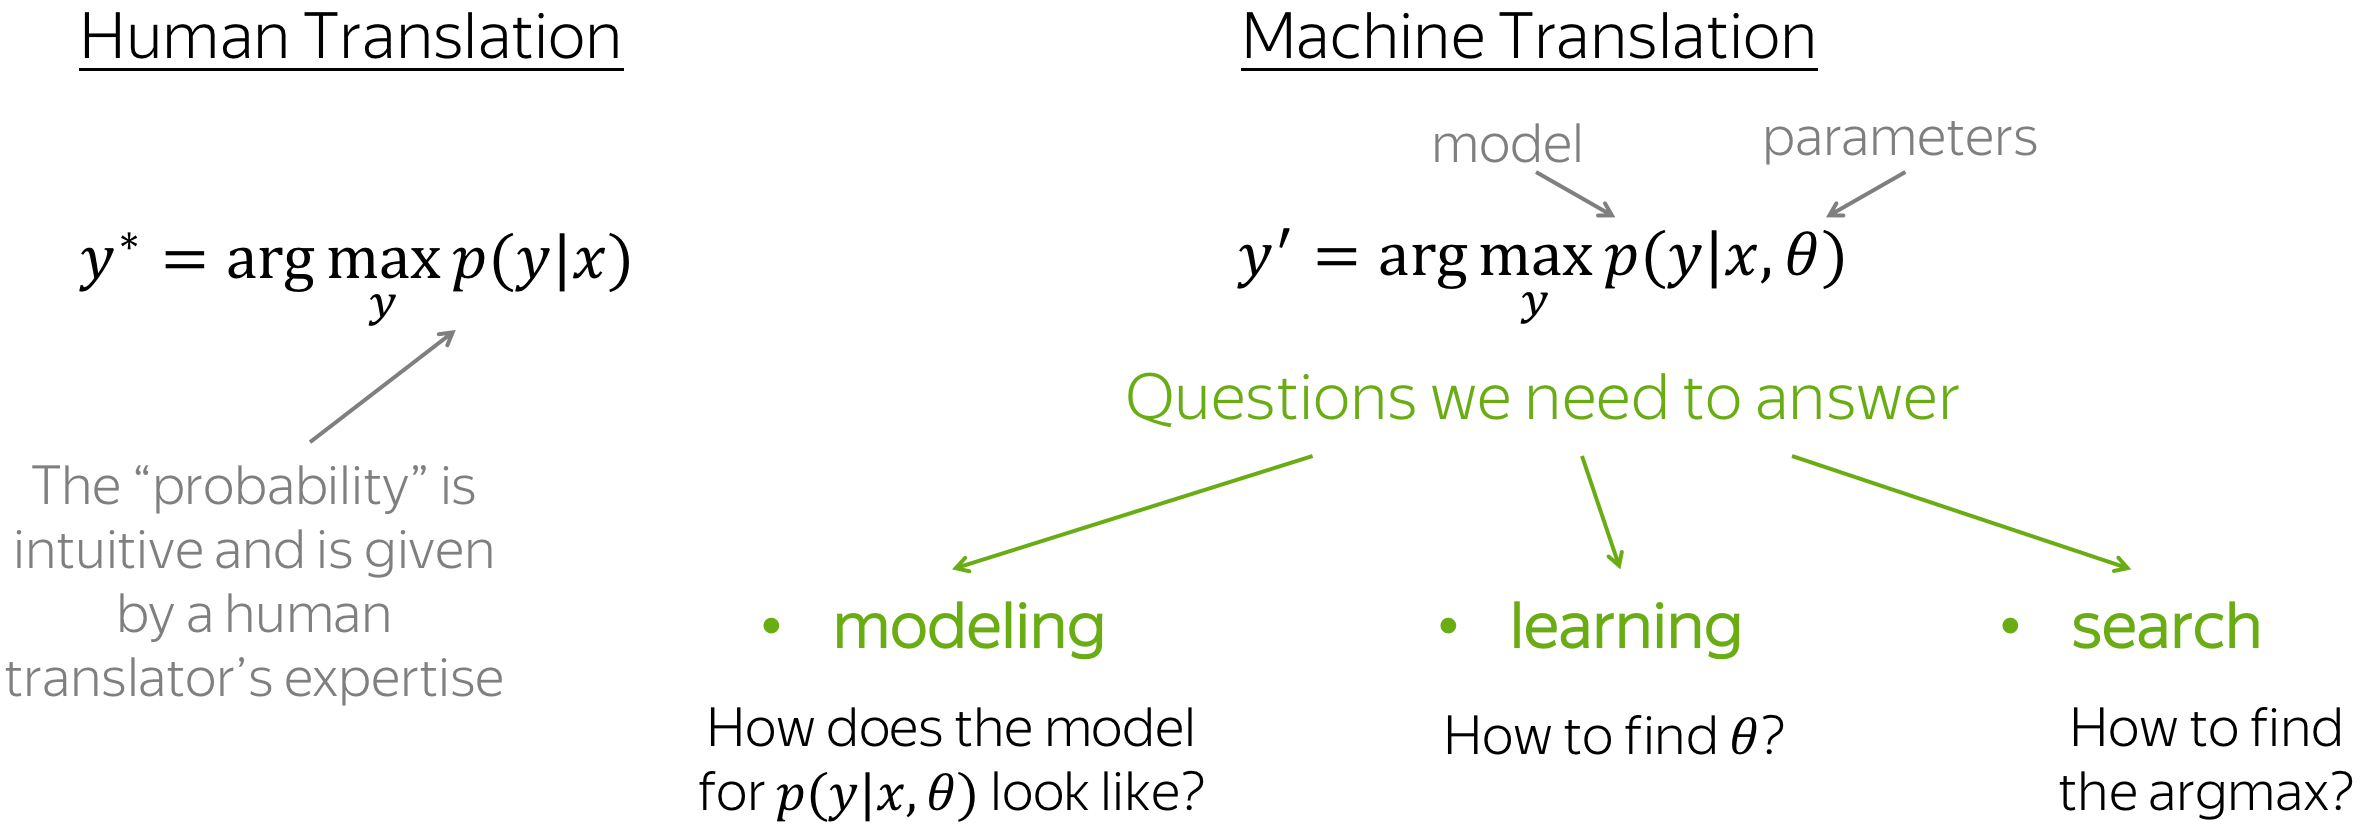

Для того чтобы определить систему машинного перевода, нам нужно ответить на три ключевых вопроса:

1. **Моделирование**: Как выглядит модель для $p(y | x, \theta)$?
2. **Обучение**: Как найти параметры $\theta$?
3. **Инференс**: Как найти лучший $y$?

В этом разделе мы сосредоточимся на ответах на второй и третий вопросы, но будем рассматривать только самую простую модель. Более сложные модели будут рассмотрены в последующих разделах, особенно в разделах, посвященных вниманию и модели Transformer.





**Фреймворк Encoder-Decoder (кодировщик-декодировщик)**

Фреймворк encoder-decoder является стандартной моделью для задач типа последовательность к последовательности. Этот фреймворк состоит из двух компонентов:
- **Кодировщик (encoder)** — читает исходную последовательность и создает её представление.
- **Декодировщик (decoder)** — использует представление, полученное от кодировщика, для генерации целевой последовательности.


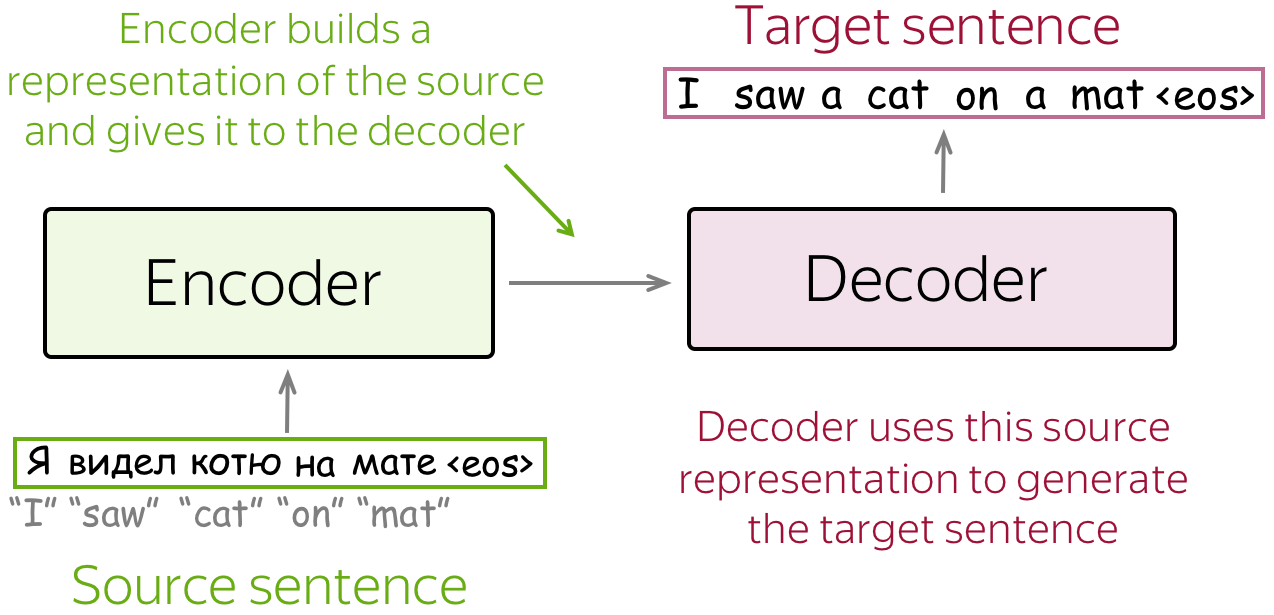


На этой лекции мы рассмотрим различные модели, но все они будут иметь структуру encoder-decoder.

**Условные языковые модели**

В лекции о языковых моделях мы изучали, как оценивать вероятность $p(y)$ последовательности токенов $y = (y_1, y_2, \dots, y_n)$. В то время как языковые модели оценивают безусловную вероятность $p(y)$ последовательности $y$, модели типа последовательность к последовательности должны оценивать условную вероятность $p(y | x)$ последовательности $y$ при условии, что дана исходная последовательность $x$. Поэтому задачи типа последовательность к последовательности могут быть смоделированы как **условные языковые модели (CLM)** — они работают аналогично языковым моделям, но дополнительно принимают исходную информацию $x$.


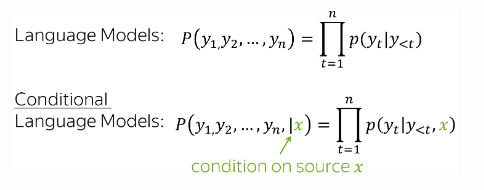


Лена: Обратите внимание, что условное языковое моделирование — это не только способ решения задач типа последовательность к последовательности. В самом общем смысле, $x$ может быть чем-то другим, кроме последовательности токенов. Например, в задаче описания изображений $x$ — это изображение, а $y$ — описание этого изображения.


<video width="640" height="480" controls autoplay muted>
  <source src="https://lena-voita.github.io/resources/lectures/seq2seq/general/enc_dec_prob_idea.mp4" type="video/mp4">
  Ваш браузер не поддерживает видео.
</video>






Поскольку единственное отличие от языковых моделей заключается в наличии источника $x$, моделирование и обучение в целом схожи с языковыми моделями. В частности, высокоуровневый процесс выглядит следующим образом:
- подавать исходные данные и ранее сгенерированные целевые слова в сеть;
- получать векторное представление контекста (как исходного, так и предыдущих целевых данных) из декодировщика сети;
- на основе этого векторного представления предсказывать распределение вероятностей для следующего токена.


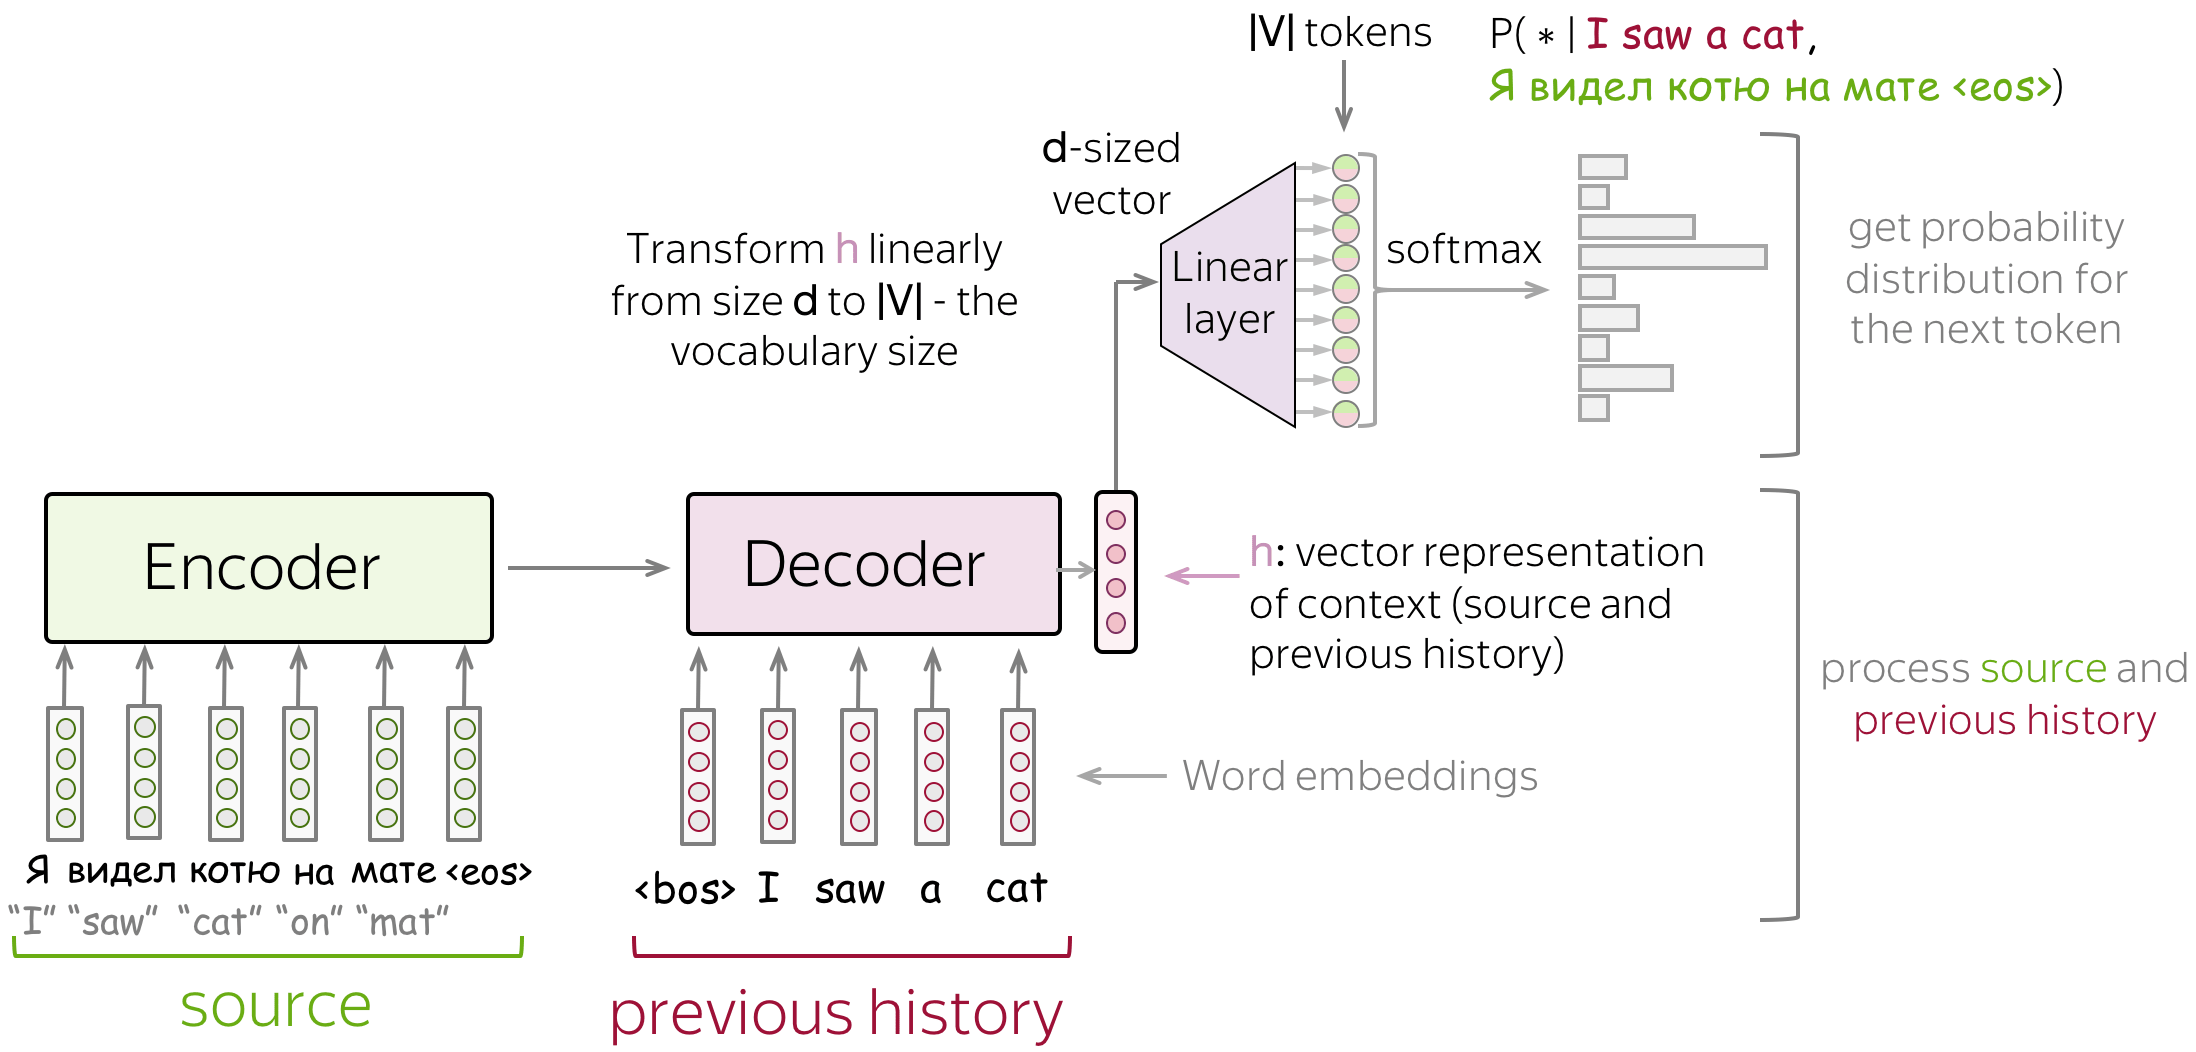




Аналогично нейронным классификаторам и языковым моделям, мы можем рассматривать часть классификации (то есть как получить вероятности токенов из векторного представления текста) очень просто. Векторное представление текста имеет размерность $d$, но в итоге нам нужен вектор размера $|V|$ (вероятности для $|V|$ токенов/классов). Чтобы получить вектор размера $|V|$ из вектора размера $d$, можно использовать линейный слой. Когда у нас есть вектор размера $|V|$, остается только применить операцию softmax, чтобы преобразовать сырые числа в вероятности токенов.

###**Самая простая модель: две RNN для кодировщика и декодера**  

Самая простая модель кодировщика-декодера состоит из двух RNN (обычно LSTM): одна используется для кодировщика, а другая — для декодера. Кодировщик (RNN) обрабатывает исходное предложение шаг за шагом, и его конечное состояние используется в качестве начального состояния для декодера (RNN). Идея заключается в том, что конечное состояние кодировщика "кодирует" всю информацию об исходном предложении, что позволяет декодеру сгенерировать целевое предложение на основе этого представления.  

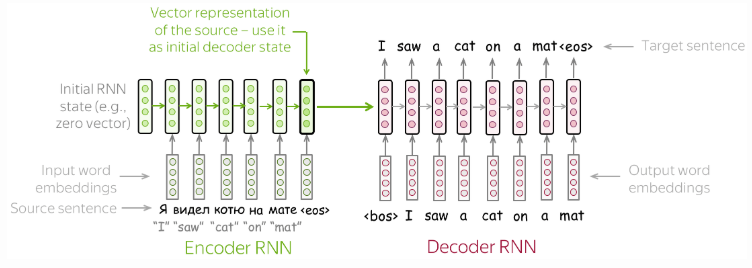



Эту базовую модель можно расширять разными способами. Например, и кодировщик, и декодер могут иметь несколько слоев. Многослойный вариант этой архитектуры был представлен в знаковой статье *Sequence to Sequence Learning with Neural Networks*, которая стала одним из первых успешных применений нейронных сетей для задач преобразования последовательностей.  

В этой же статье авторы исследовали конечное состояние кодировщика и визуализировали его для нескольких примеров. Удивительно, но оказалось, что представления предложений с похожими значениями, но разной синтаксической структурой, находятся близко друг к другу в закодированном пространстве. Ниже приведены некоторые примеры из статьи.  

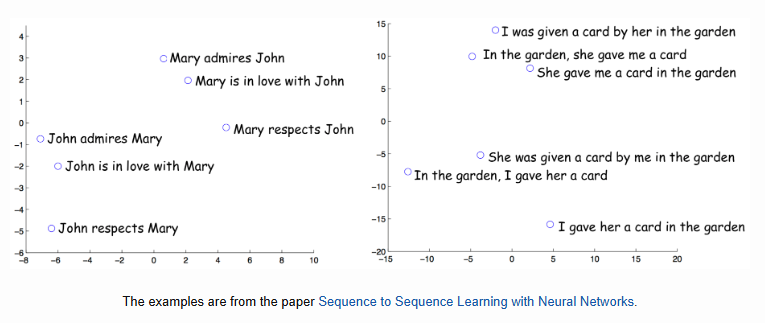



Статья [Sequence to Sequence Learning with Neural Networks](https://arxiv.org/pdf/1409.3215.pdf) также представила элегантный прием, позволяющий улучшить работу этой простой модели на основе LSTM. Вы можете подробнее изучить эту идею в упражнении из раздела "Научное мышление".  



**Обучение: Функция потерь на основе кросс-энтропии (еще раз)**  

Лена: Это та же функция потерь на основе кросс-энтропии, которую мы уже обсуждали на лекциях по классификации текста и языковому моделированию. Вы можете пропустить этот раздел или быстро просмотреть его :)  

Подобно нейросетевым языковым моделям, seq2seq-модели обучаются предсказывать распределение вероятностей следующего токена на основе предыдущего контекста (включая исходную последовательность и предыдущие токены целевой последовательности). Интуитивно, на каждом шаге мы стремимся максимизировать вероятность, которую модель присваивает правильному токену.  

Формально, рассмотрим обучающий пример с исходной последовательностью $x = (x_1, \dots, x_m)$ и целевой последовательностью $y = (y_1, \dots, y_n)$. На временном шаге $t$ модель предсказывает распределение вероятностей $p^{(t)} = p(* | y_1, \dots, y_{t-1}, x_1, \dots, x_m)$. Целевое значение на этом шаге: $p^* = \text{one-hot}(y_t)$, то есть мы хотим, чтобы модель присвоила токену $y_t$ вероятность 1, а остальным токенам — 0.  

Стандартной функцией потерь является функция кросс-энтропии. Функция потерь для целевого распределения $p^*$ и предсказанного распределения $p$ записывается как:  
$$
\text{Loss}(p^*, p) = -p^* \log(p) = -\sum_{i=1}^{|V|} p_i^* \log(p_i).
$$  

Поскольку только одно значение в $p_i^*$ ненулевое (соответствующее правильному токену $y_t$), функция упрощается до:  
$$
\text{Loss}(p^*, p) = -\log(p_{y_t}) = -\log(p(y_t | y_{<t}, x)).
$$  

На каждом шаге мы максимизируем вероятность, которую модель присваивает правильному токену. Посмотрите иллюстрацию для одного временного шага, чтобы лучше понять процесс.  



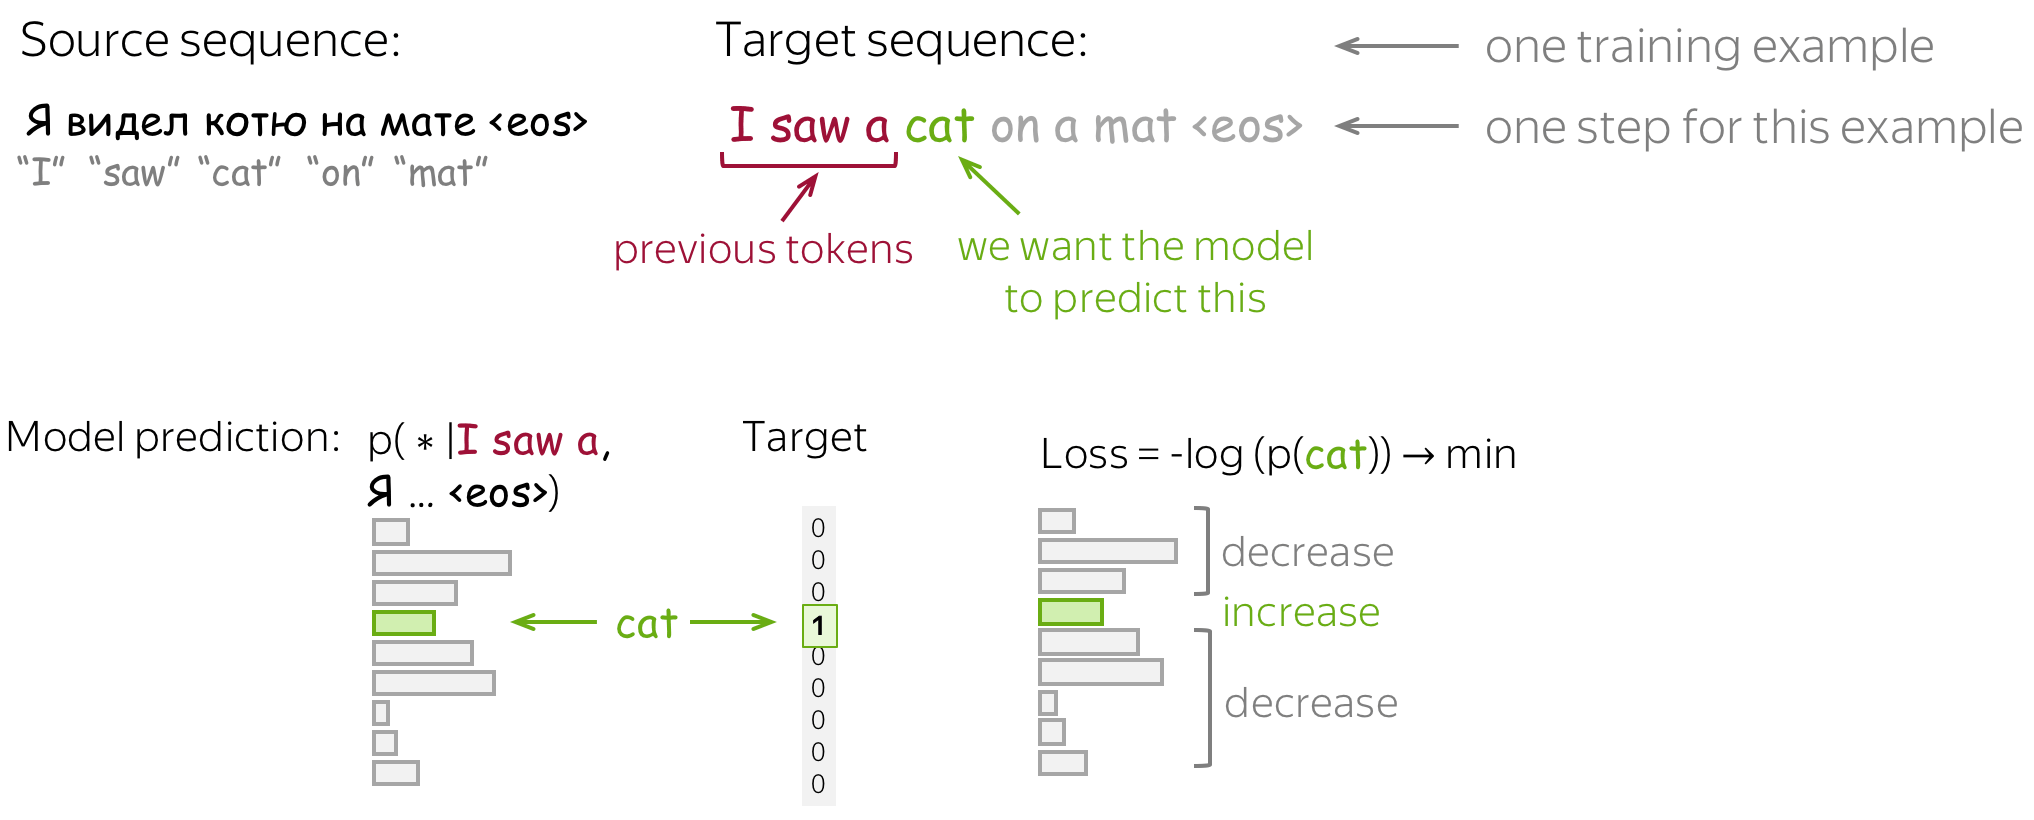

Для всей последовательности общая функция потерь выглядит так:  
$$
-\sum_{t=1}^{n} \log(p(y_t | y_{<t}, x)).
$$  

Обратите внимание на иллюстрацию процесса обучения. Пример показан для модели на основе RNN, но тот же принцип применим и к другим архитектурам.  





<video width="640" height="480" controls autoplay muted>
  <source src="https://lena-voita.github.io/resources/lectures/seq2seq/general/seq2seq_training_with_target.mp4" type="video/mp4">
  Ваш браузер не поддерживает видео.
</video>



**Вывод: Жадное декодирование и поиск по лучу**  

Теперь, когда мы понимаем, как устроена модель и как её обучать, давайте подумаем, как с её помощью можно сгенерировать перевод. Вероятность предложения в модели определяется следующим образом:  

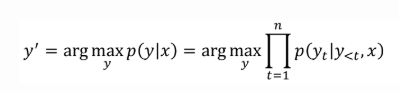


Главный вопрос: как найти последовательность, которая максимизирует эту вероятность (argmax)?  

Важно отметить, что найти точное решение на практике невозможно. Общее количество гипотез, которые нужно проверить, равно $|V|^n$, что экспоненциально растёт с длиной предложения $n$ и размером словаря $|V|$. Поэтому мы используем приближённые методы для поиска решения.  

**Лена:** На практике приближённые решения часто оказываются лучше точных, которые могут переоценивать маловероятные, но формально оптимальные последовательности.  

### Жадное декодирование: выбор самого вероятного токена на каждом шаге  
Простой подход — **жадное декодирование**: на каждом шаге выбирается токен с наивысшей вероятностью. Хотя этот метод может служить базовым, он имеет значительные ограничения. Выбор самого вероятного токена на текущем шаге не гарантирует наилучшей общей последовательности, так как локальные решения могут противоречить глобальному оптимуму.  


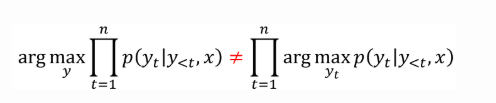


### Поиск по лучу: отслеживание нескольких гипотез  
Более эффективным подходом является **поиск по лучу**, при котором одновременно отслеживается несколько гипотез. На каждом шаге каждая гипотеза расширяется за счёт возможных следующих токенов, а затем сохраняются только $N$ самых вероятных последовательностей. Это позволяет модели исследовать несколько перспективных путей.  



<video width="640" height="480" controls autoplay muted>
  <source src="https://lena-voita.github.io/resources/lectures/seq2seq/general/beam_search.mp4" type="video/mp4">
  Ваш браузер не поддерживает видео.
</video>



Обычно размер луча (количество отслеживаемых гипотез) составляет от 4 до 10. Сильное увеличение размера луча становится вычислительно неэффективным и, что важнее, зачастую приводит к ухудшению качества.  




###**Внимание**  
**Проблема фиксированного представления энкодера**  

**Проблема:** фиксированное представление источника является неэффективным:  
1. Для энкодера сложно сжать предложение в ограниченное представление.  
2. Для декодера на разных этапах может быть важна разная информация.  

В рассмотренных нами моделях энкодер сжимал всё исходное предложение в один вектор. Это может быть чрезвычайно сложно, так как количество возможных исходных предложений (а значит, и их значений) бесконечно. Если энкодер вынужден поместить всю информацию в один вектор, он, скорее всего, что-то упустит.  


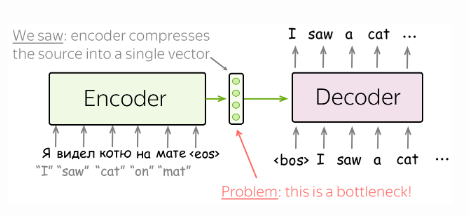


Лена: Представьте себе всю вселенную во всей её красоте — попробуйте визуализировать всё, что там есть, и описать это словами. А теперь представьте, что всё это сжато в один вектор размером, например, 512. Кажется ли вам, что вселенная всё ещё в порядке?  

Это сложно не только для энкодера, но и для декодера. Декодер видит только одну фиксированную репрезентацию источника. Однако на каждом шаге генерации разные части исходного предложения могут быть более полезны, чем другие. В текущей настройке декодер должен извлекать релевантную информацию из одного фиксированного представления — задача, мягко говоря, непростая.  



**Внимание: Общий обзор**  

Механизм внимания был представлен в статье *"Neural Machine Translation by Jointly Learning to Align and Translate"* для решения проблемы фиксированного представления.  

**Внимание:** на разных этапах модель может "фокусироваться" на различных частях входных данных.  

Механизм внимания является частью нейронной сети. На каждом шаге декодера он определяет, какие части источника более важны. В этом подходе энкодер не обязан сжимать весь источник в один вектор — вместо этого он создаёт представления для всех токенов источника (например, сохраняет все состояния RNN, а не только последнее).  




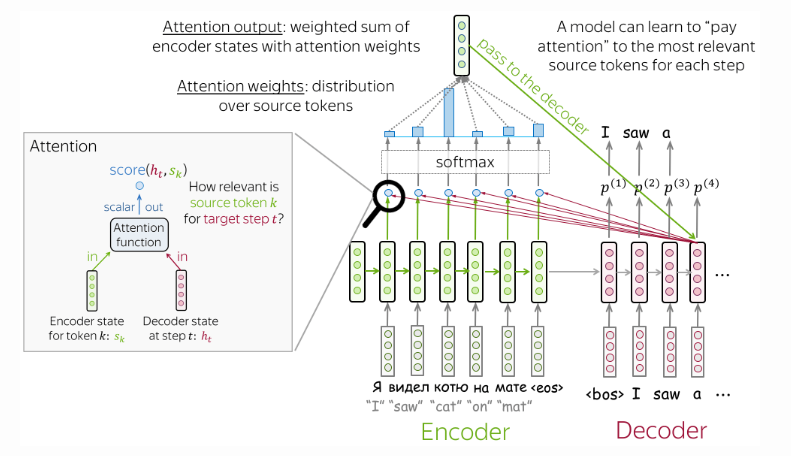


**На каждом шаге декодера механизм внимания:**  
1. **Получает входные данные для внимания:** состояние декодера $h_t$ и все состояния энкодера $s_1, s_2, \dots, s_m$.  
2. **Вычисляет оценки внимания:**  
   Для каждого состояния энкодера $s_k$ внимание определяет его "релевантность" для текущего состояния декодера $h_t$. Формально применяется функция внимания, которая принимает одно состояние декодера и одно состояние энкодера, возвращая скалярное значение $\text{score}(h_t, s_k)$.  
3. **Вычисляет весовые коэффициенты внимания:**  
   Полученная оценка преобразуется в вероятностное распределение с помощью softmax, применённого к оценкам внимания.  
4. **Вычисляет выход внимания:**  
   Это взвешенная сумма состояний энкодера с весами, определёнными на предыдущем этапе.  

Общая схема вычислений представлена ниже.  


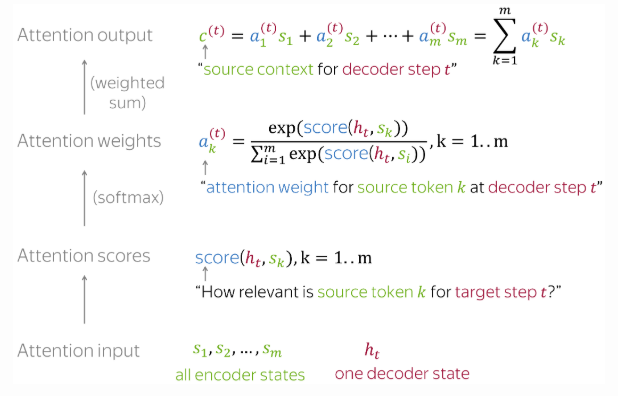


**Замечание:** Всё дифференцируемо — обучение сквозное!  

Главная идея заключается в том, что сеть может научиться определять, какие части входных данных наиболее важны на каждом шаге. Так как все используемые компоненты (функция внимания, softmax и другие) являются дифференцируемыми, модель с механизмом внимания можно обучать сквозным образом.  

Нет необходимости специально обучать модель выбирать нужные слова — она самостоятельно научится выделять важную информацию.  



**Что делать:**  
Просмотрите слайды в удобном для вас темпе. Постарайтесь обратить внимание на то, как меняются весовые коэффициенты внимания на каждом шаге. Какие слова оказываются наиболее важными на каждом этапе?  



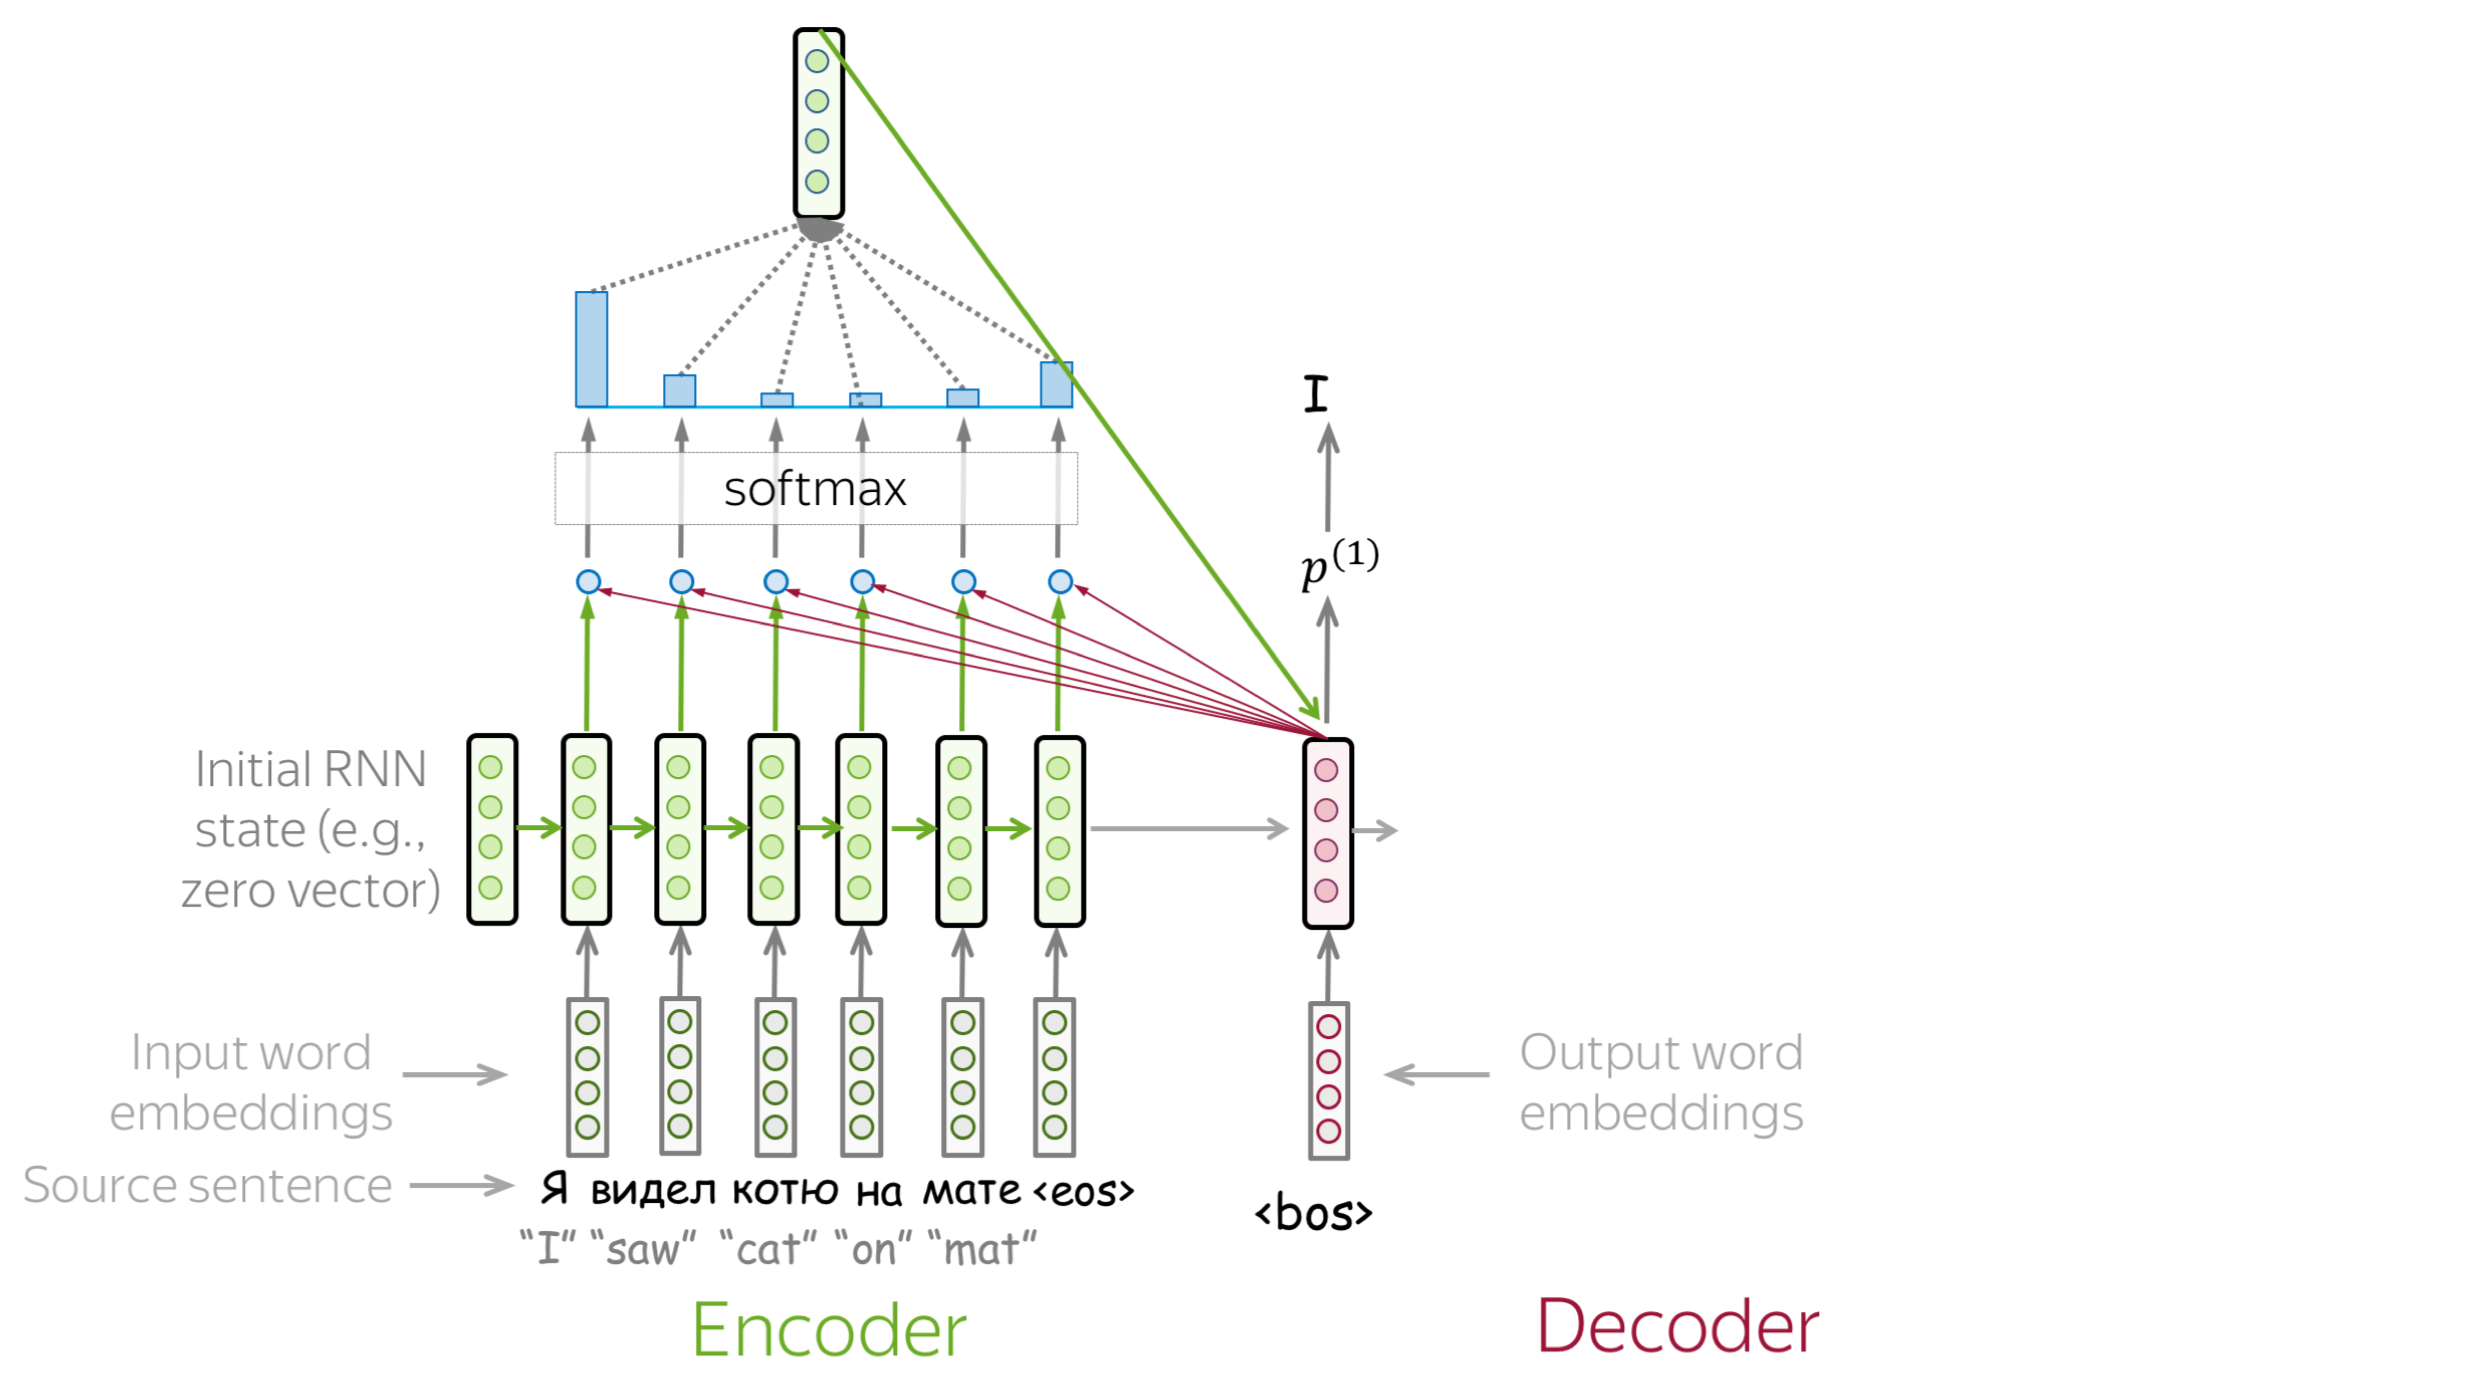

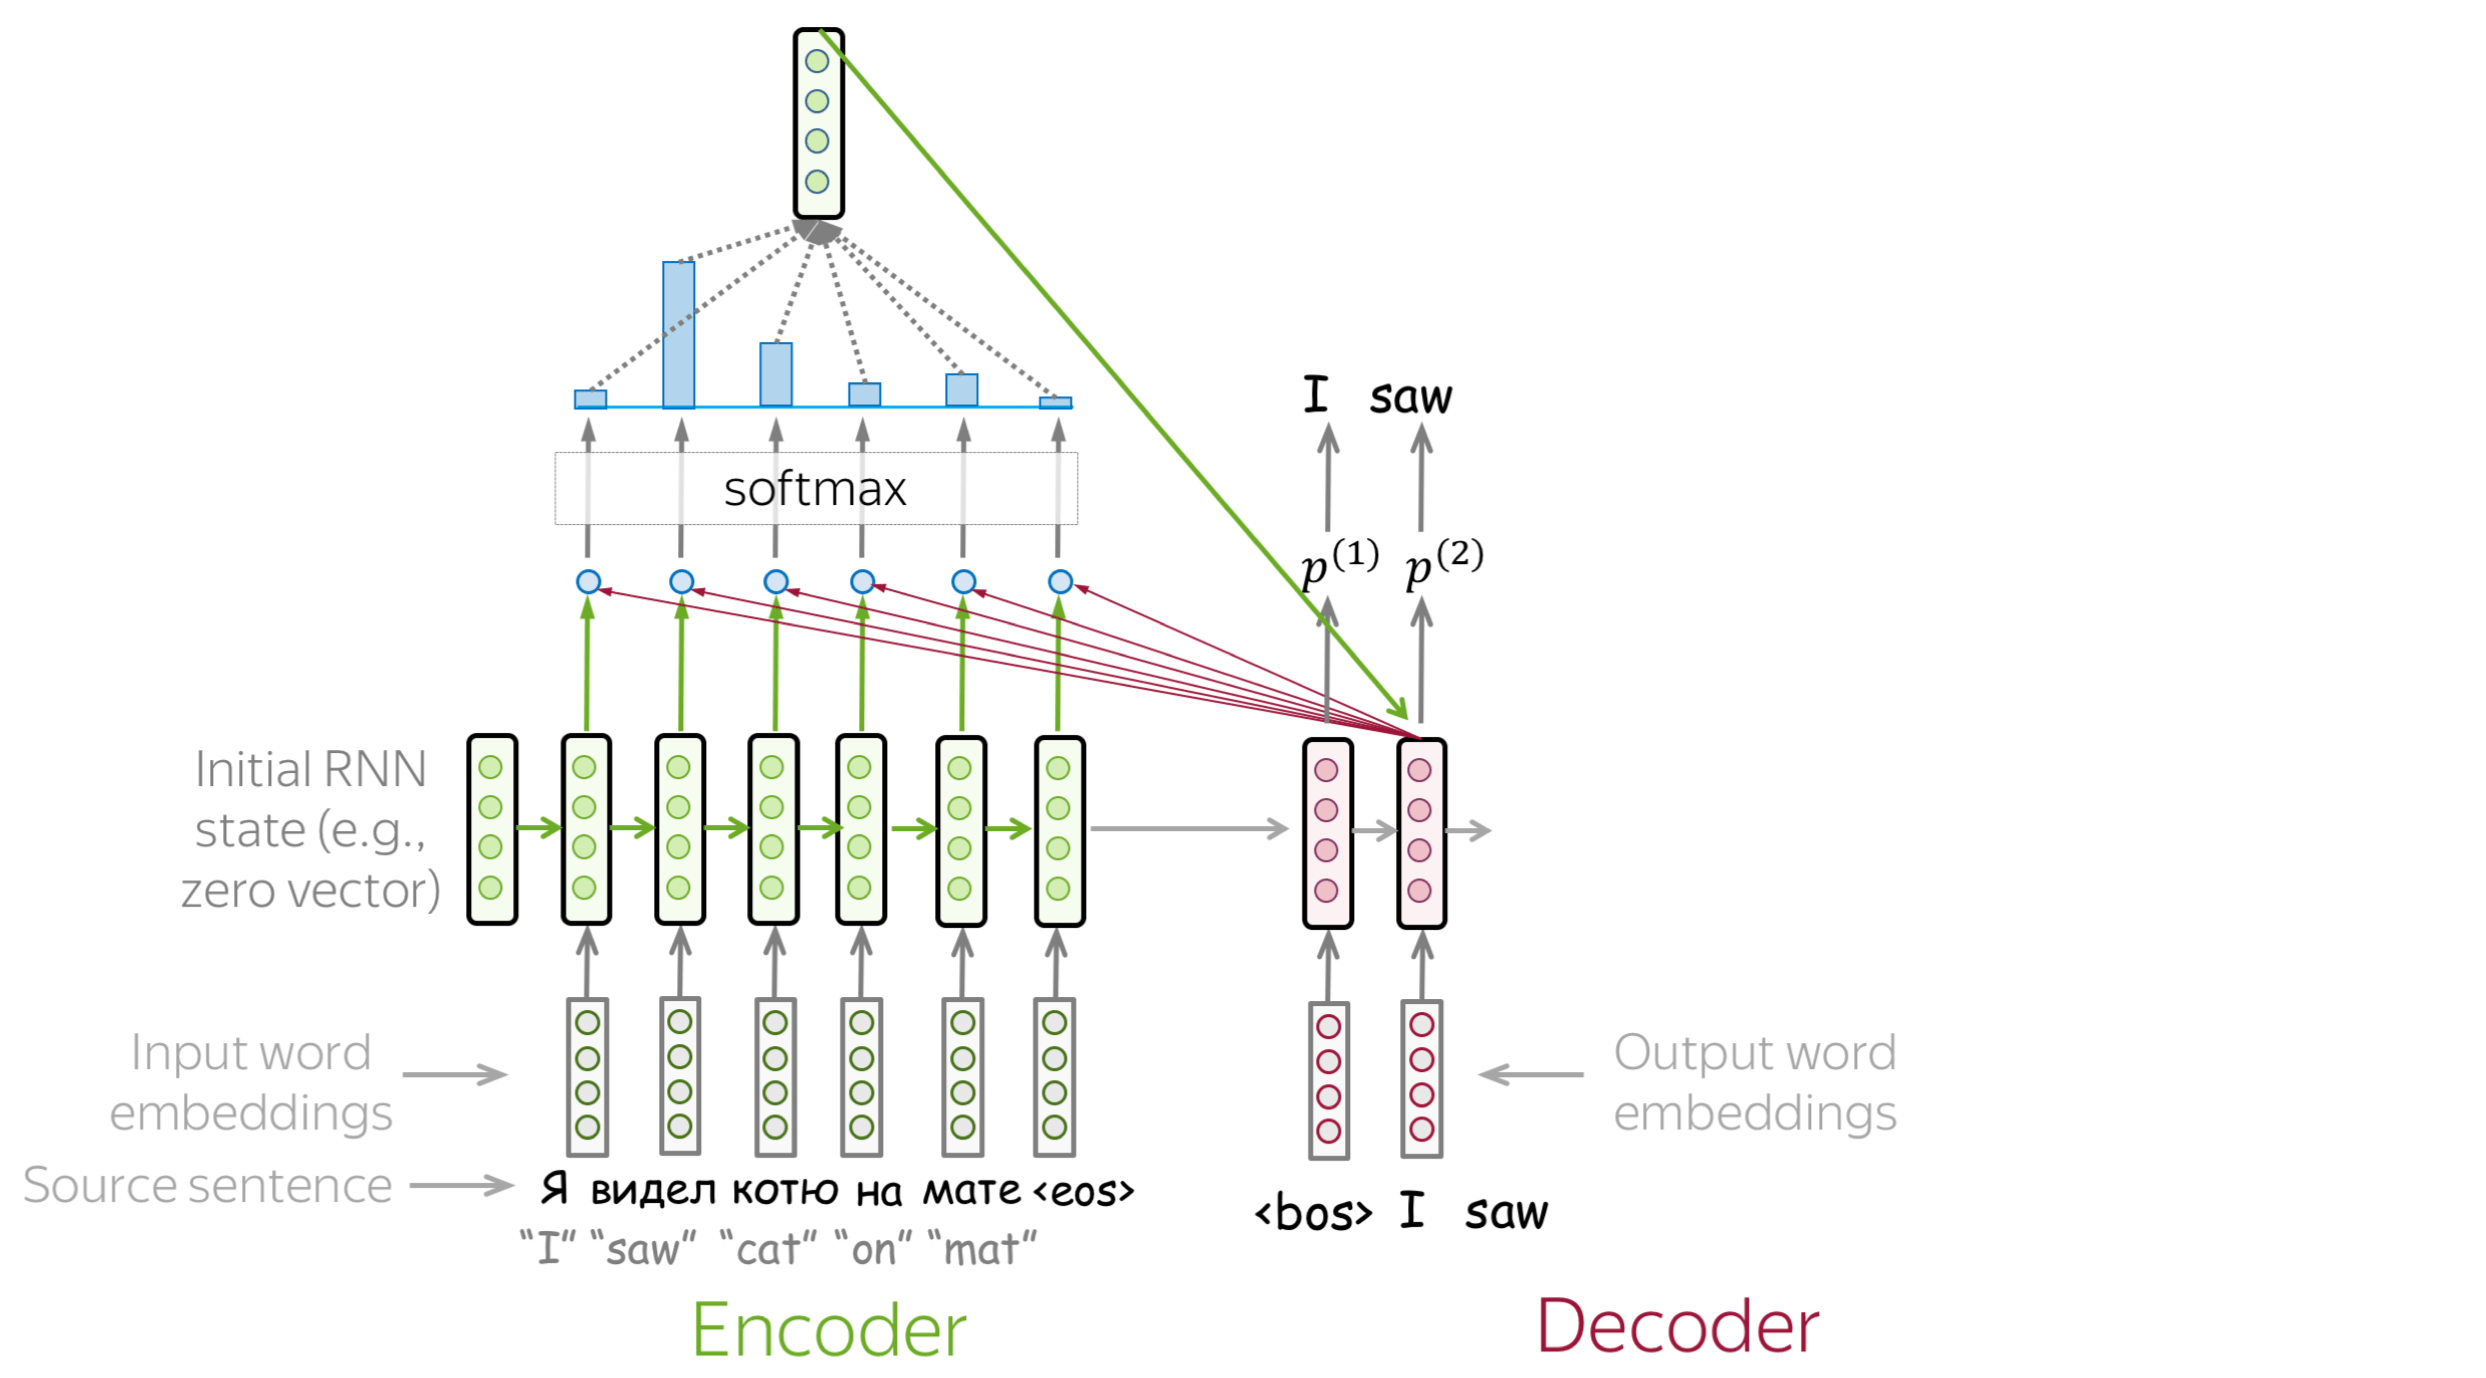

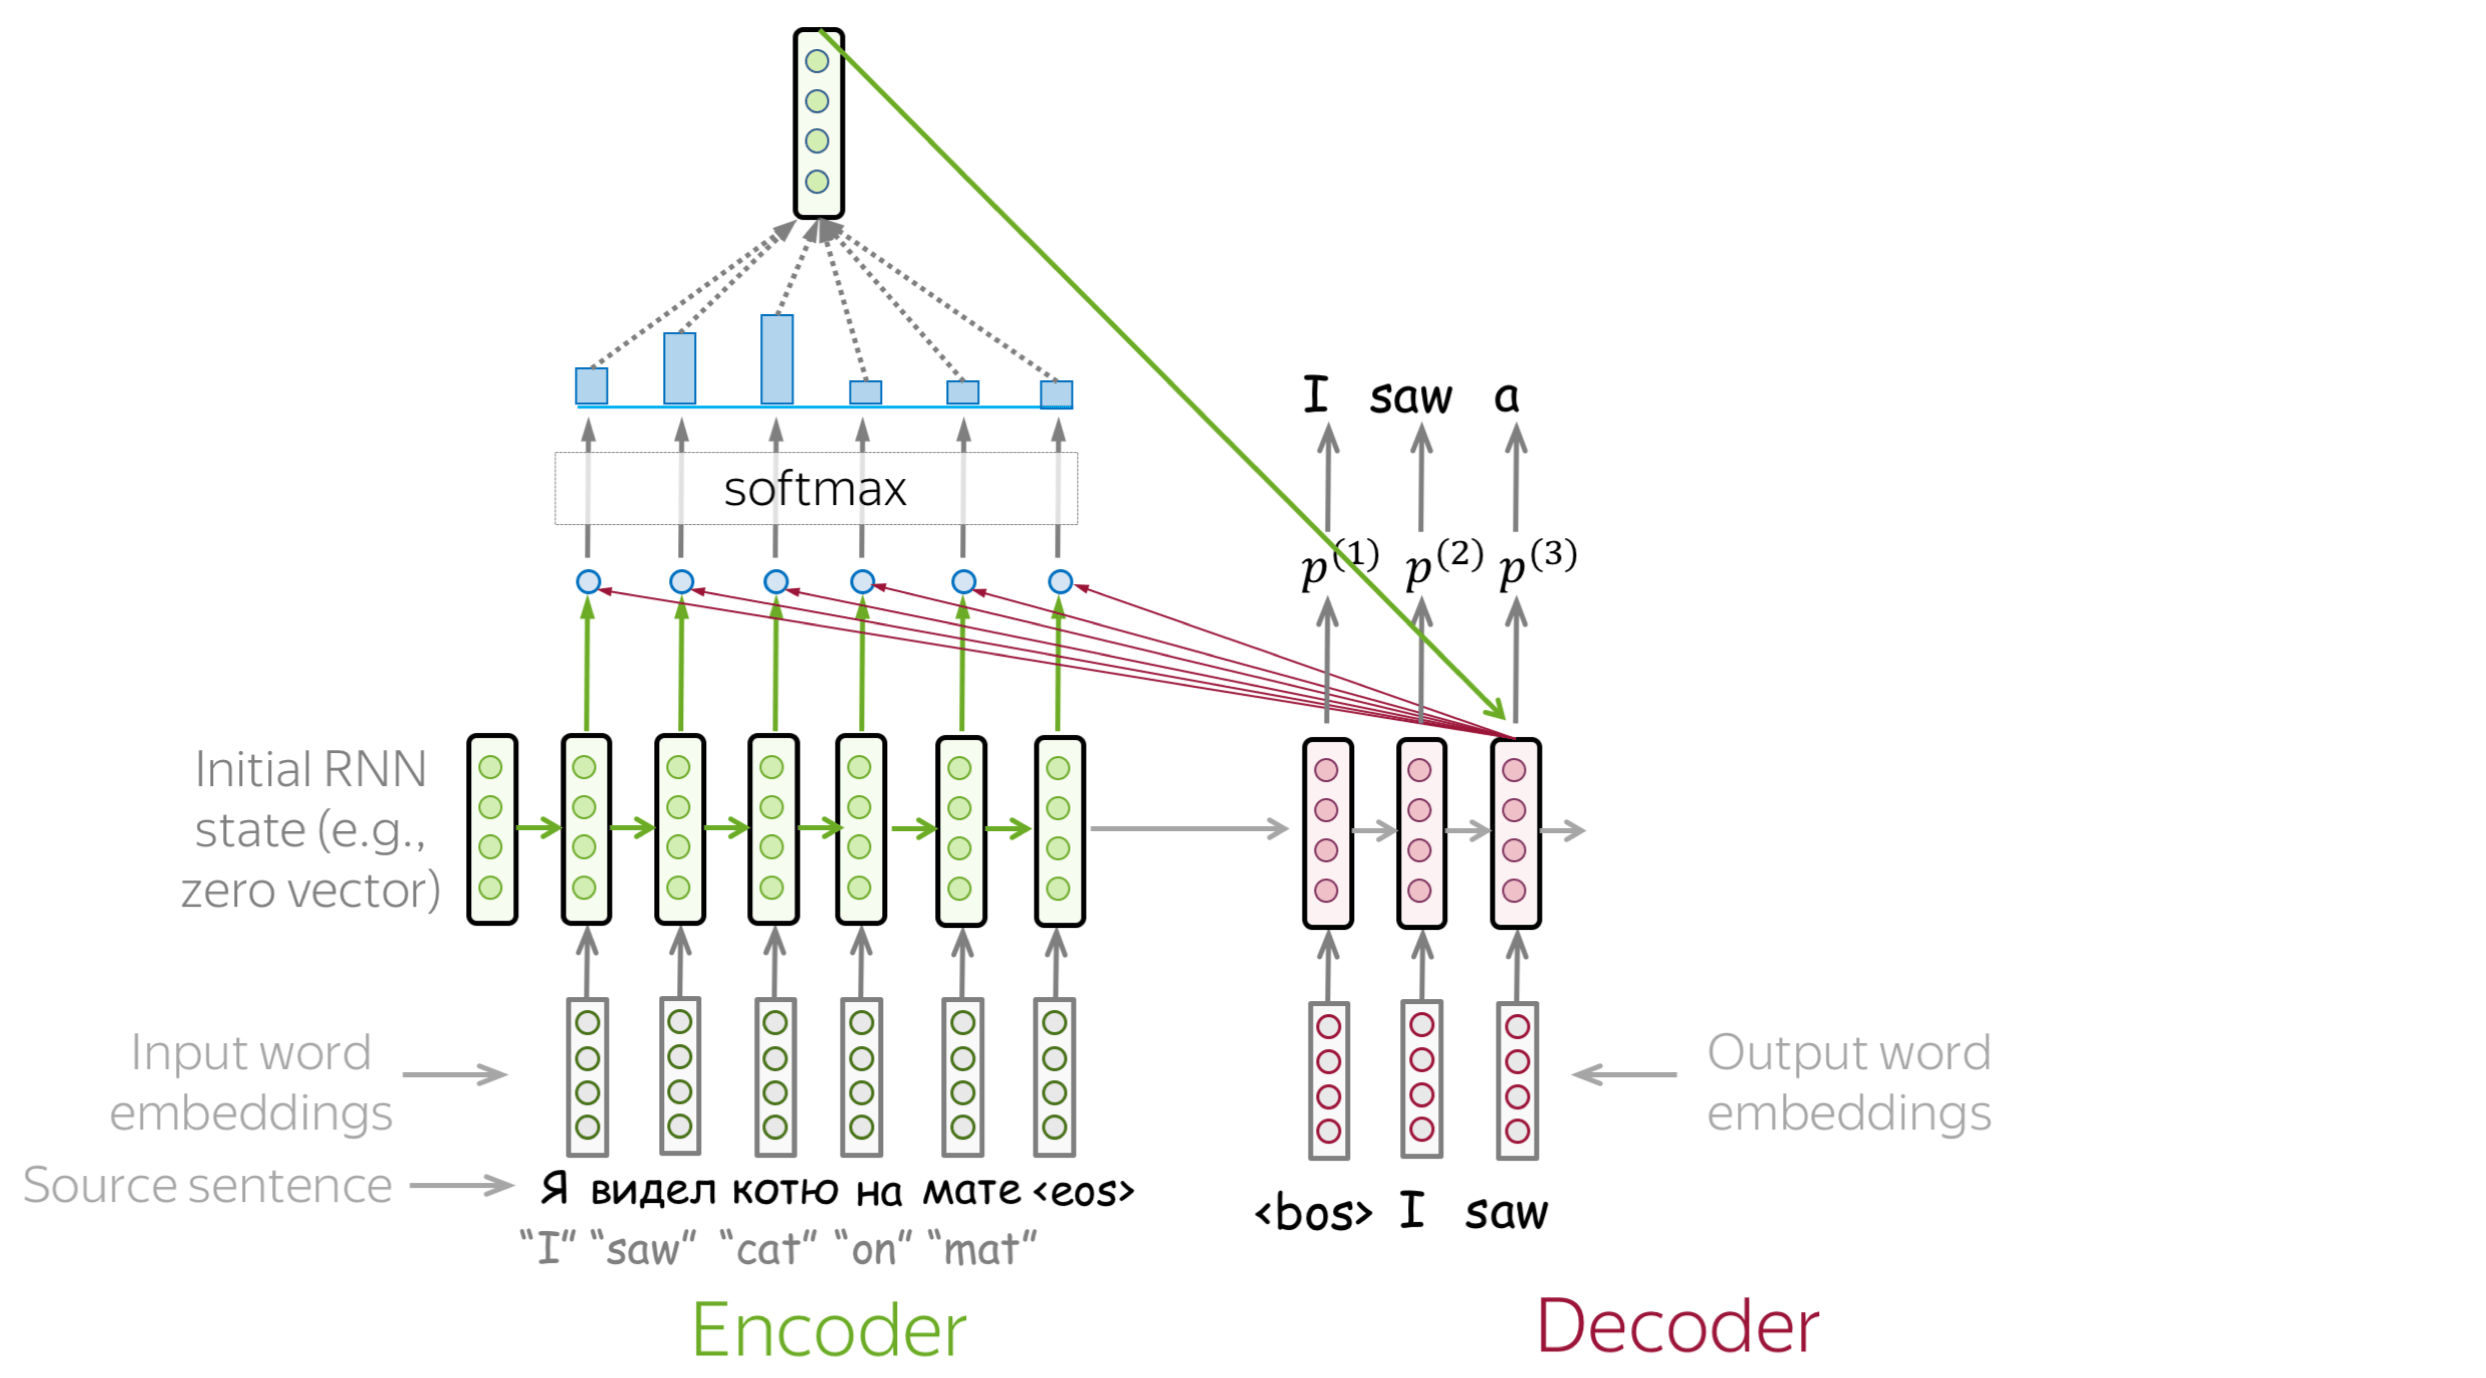

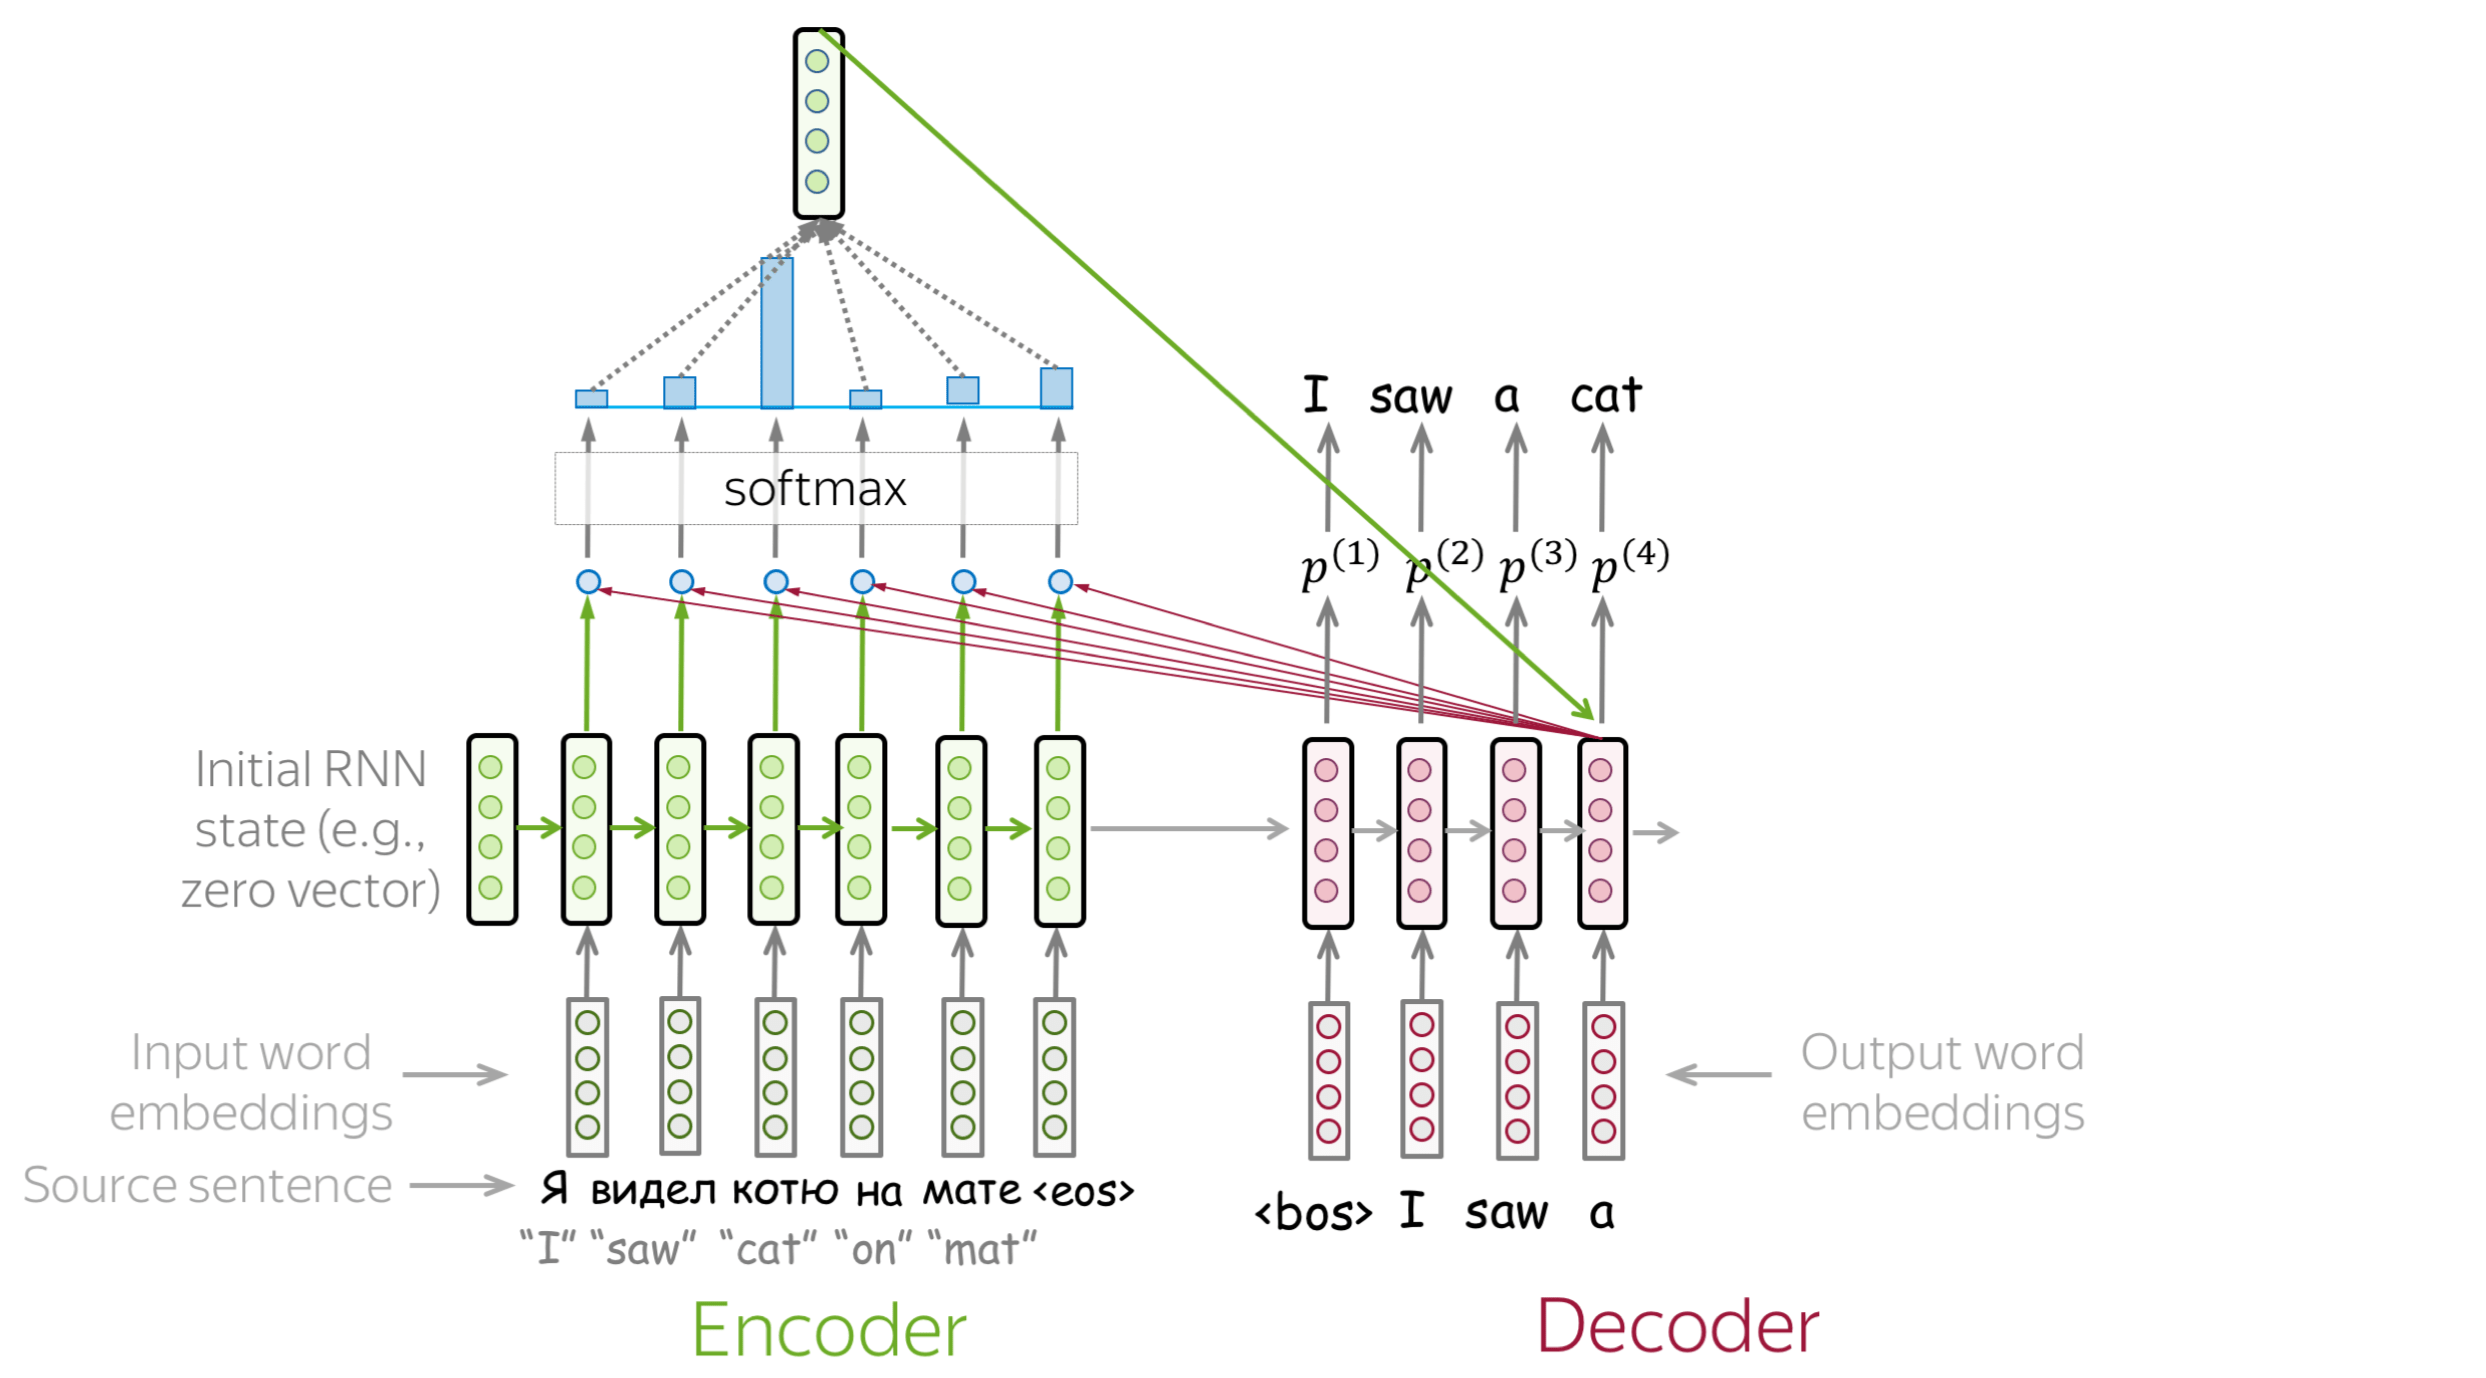

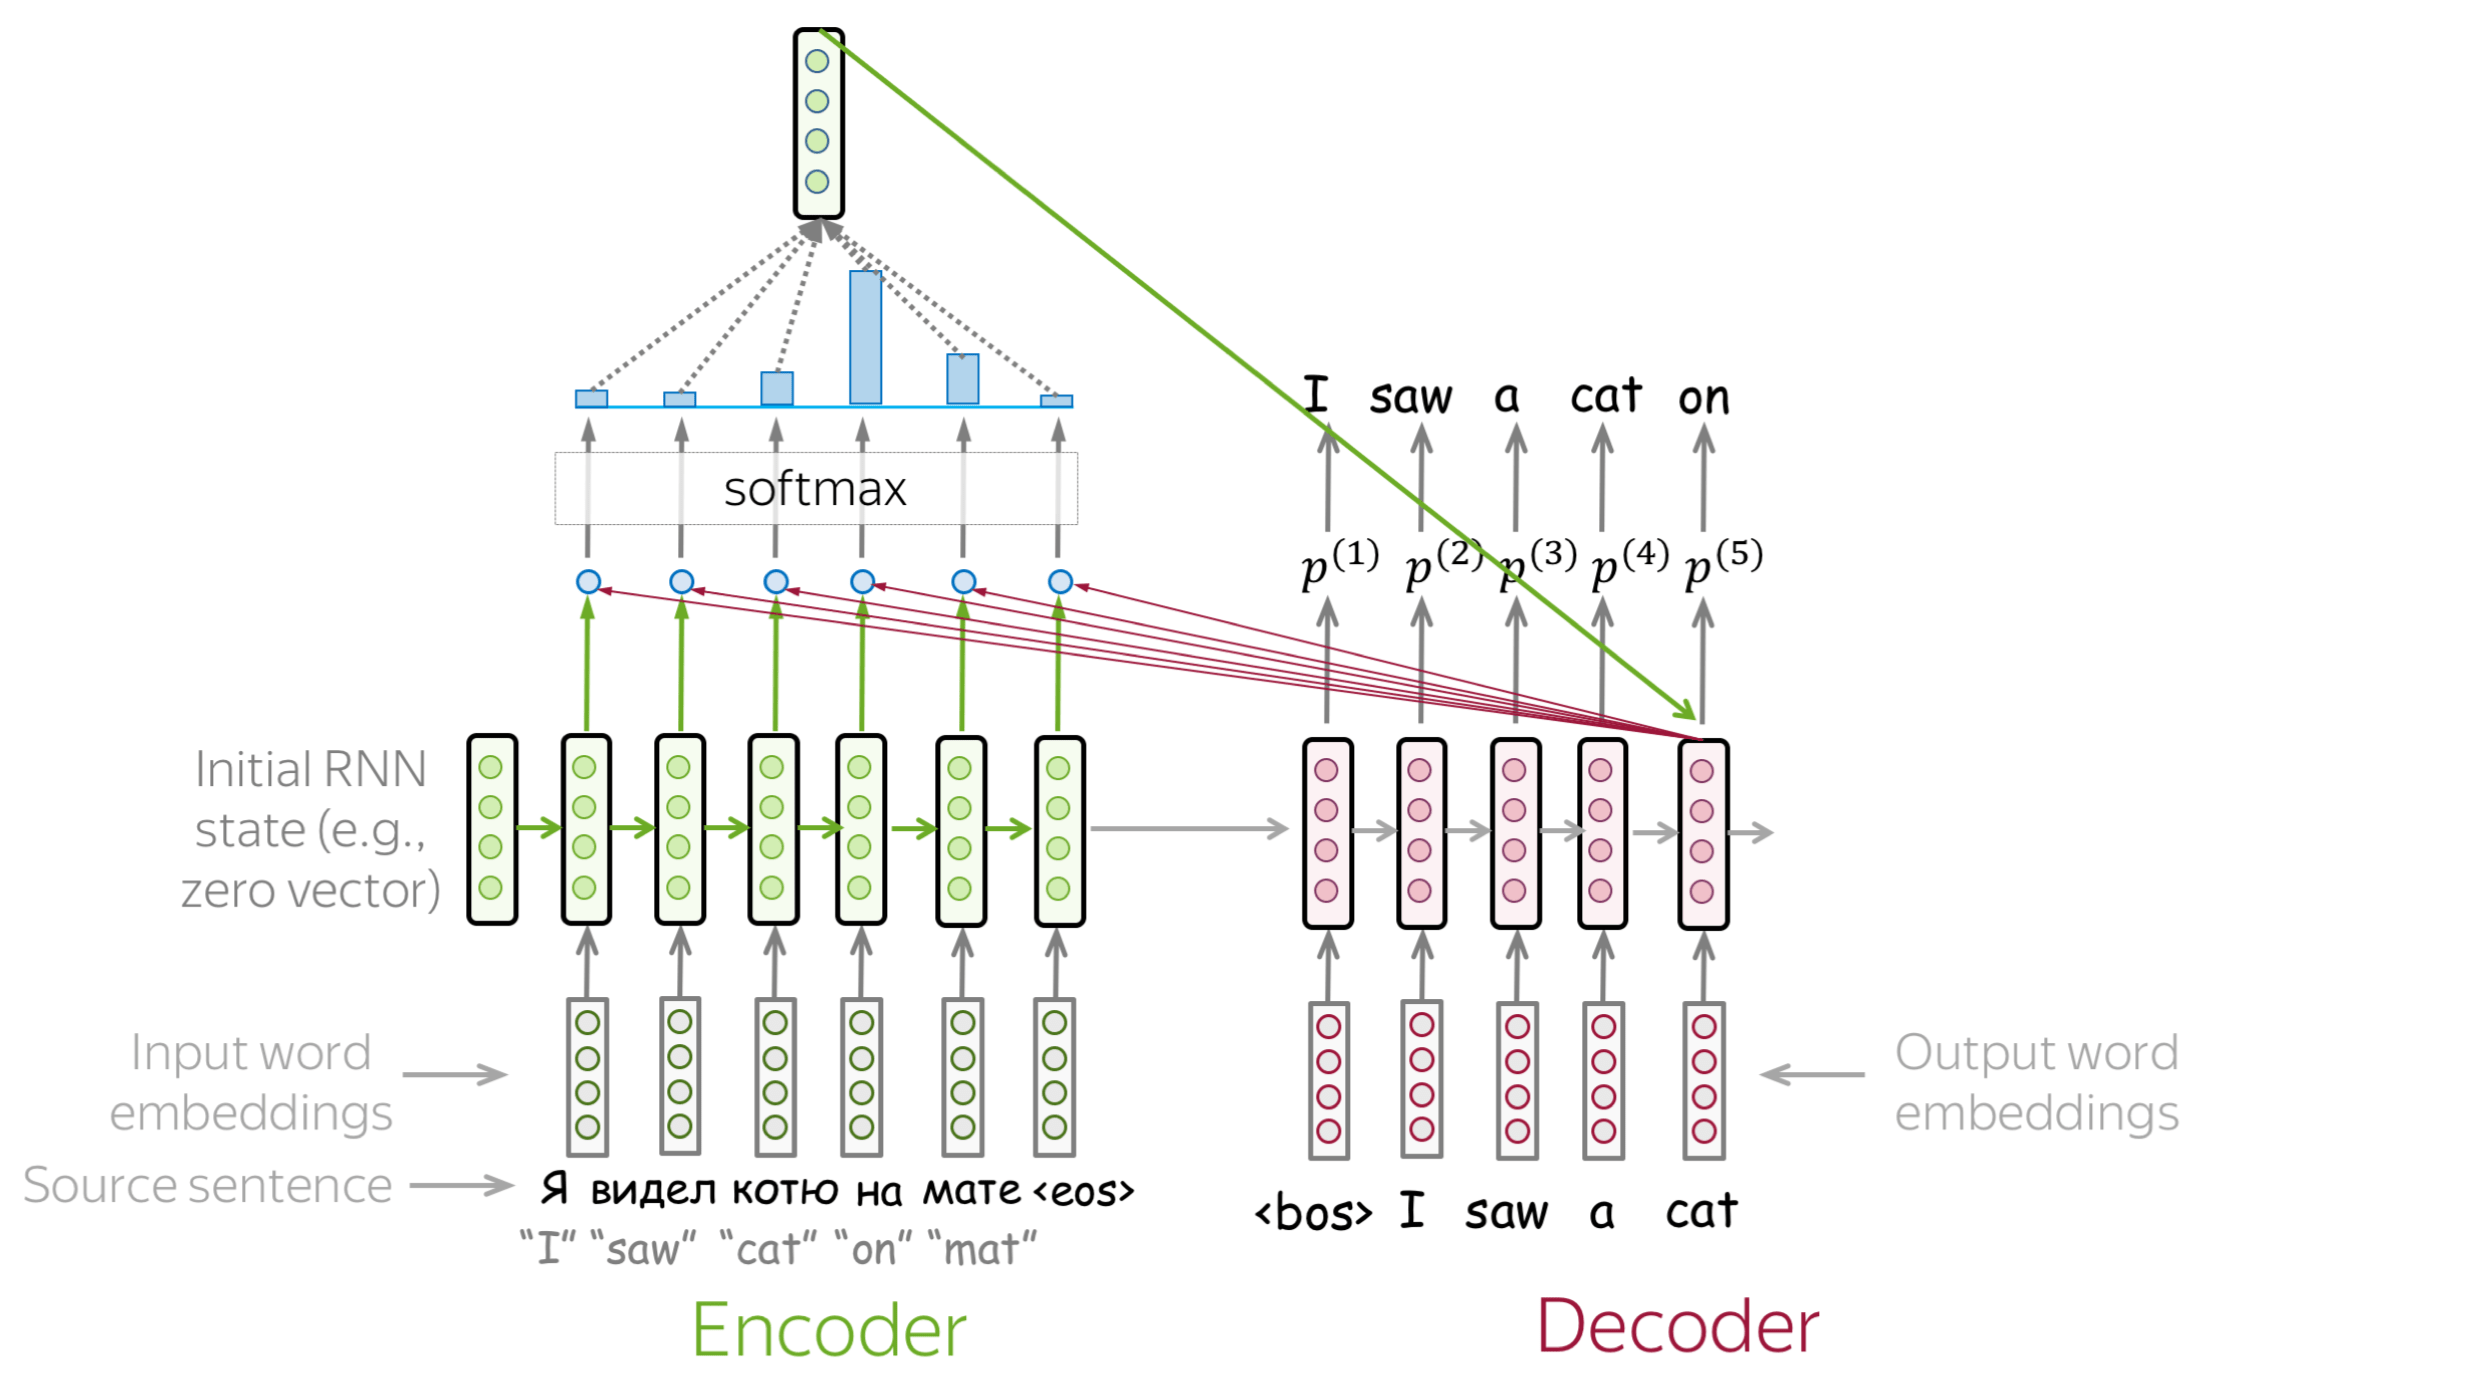

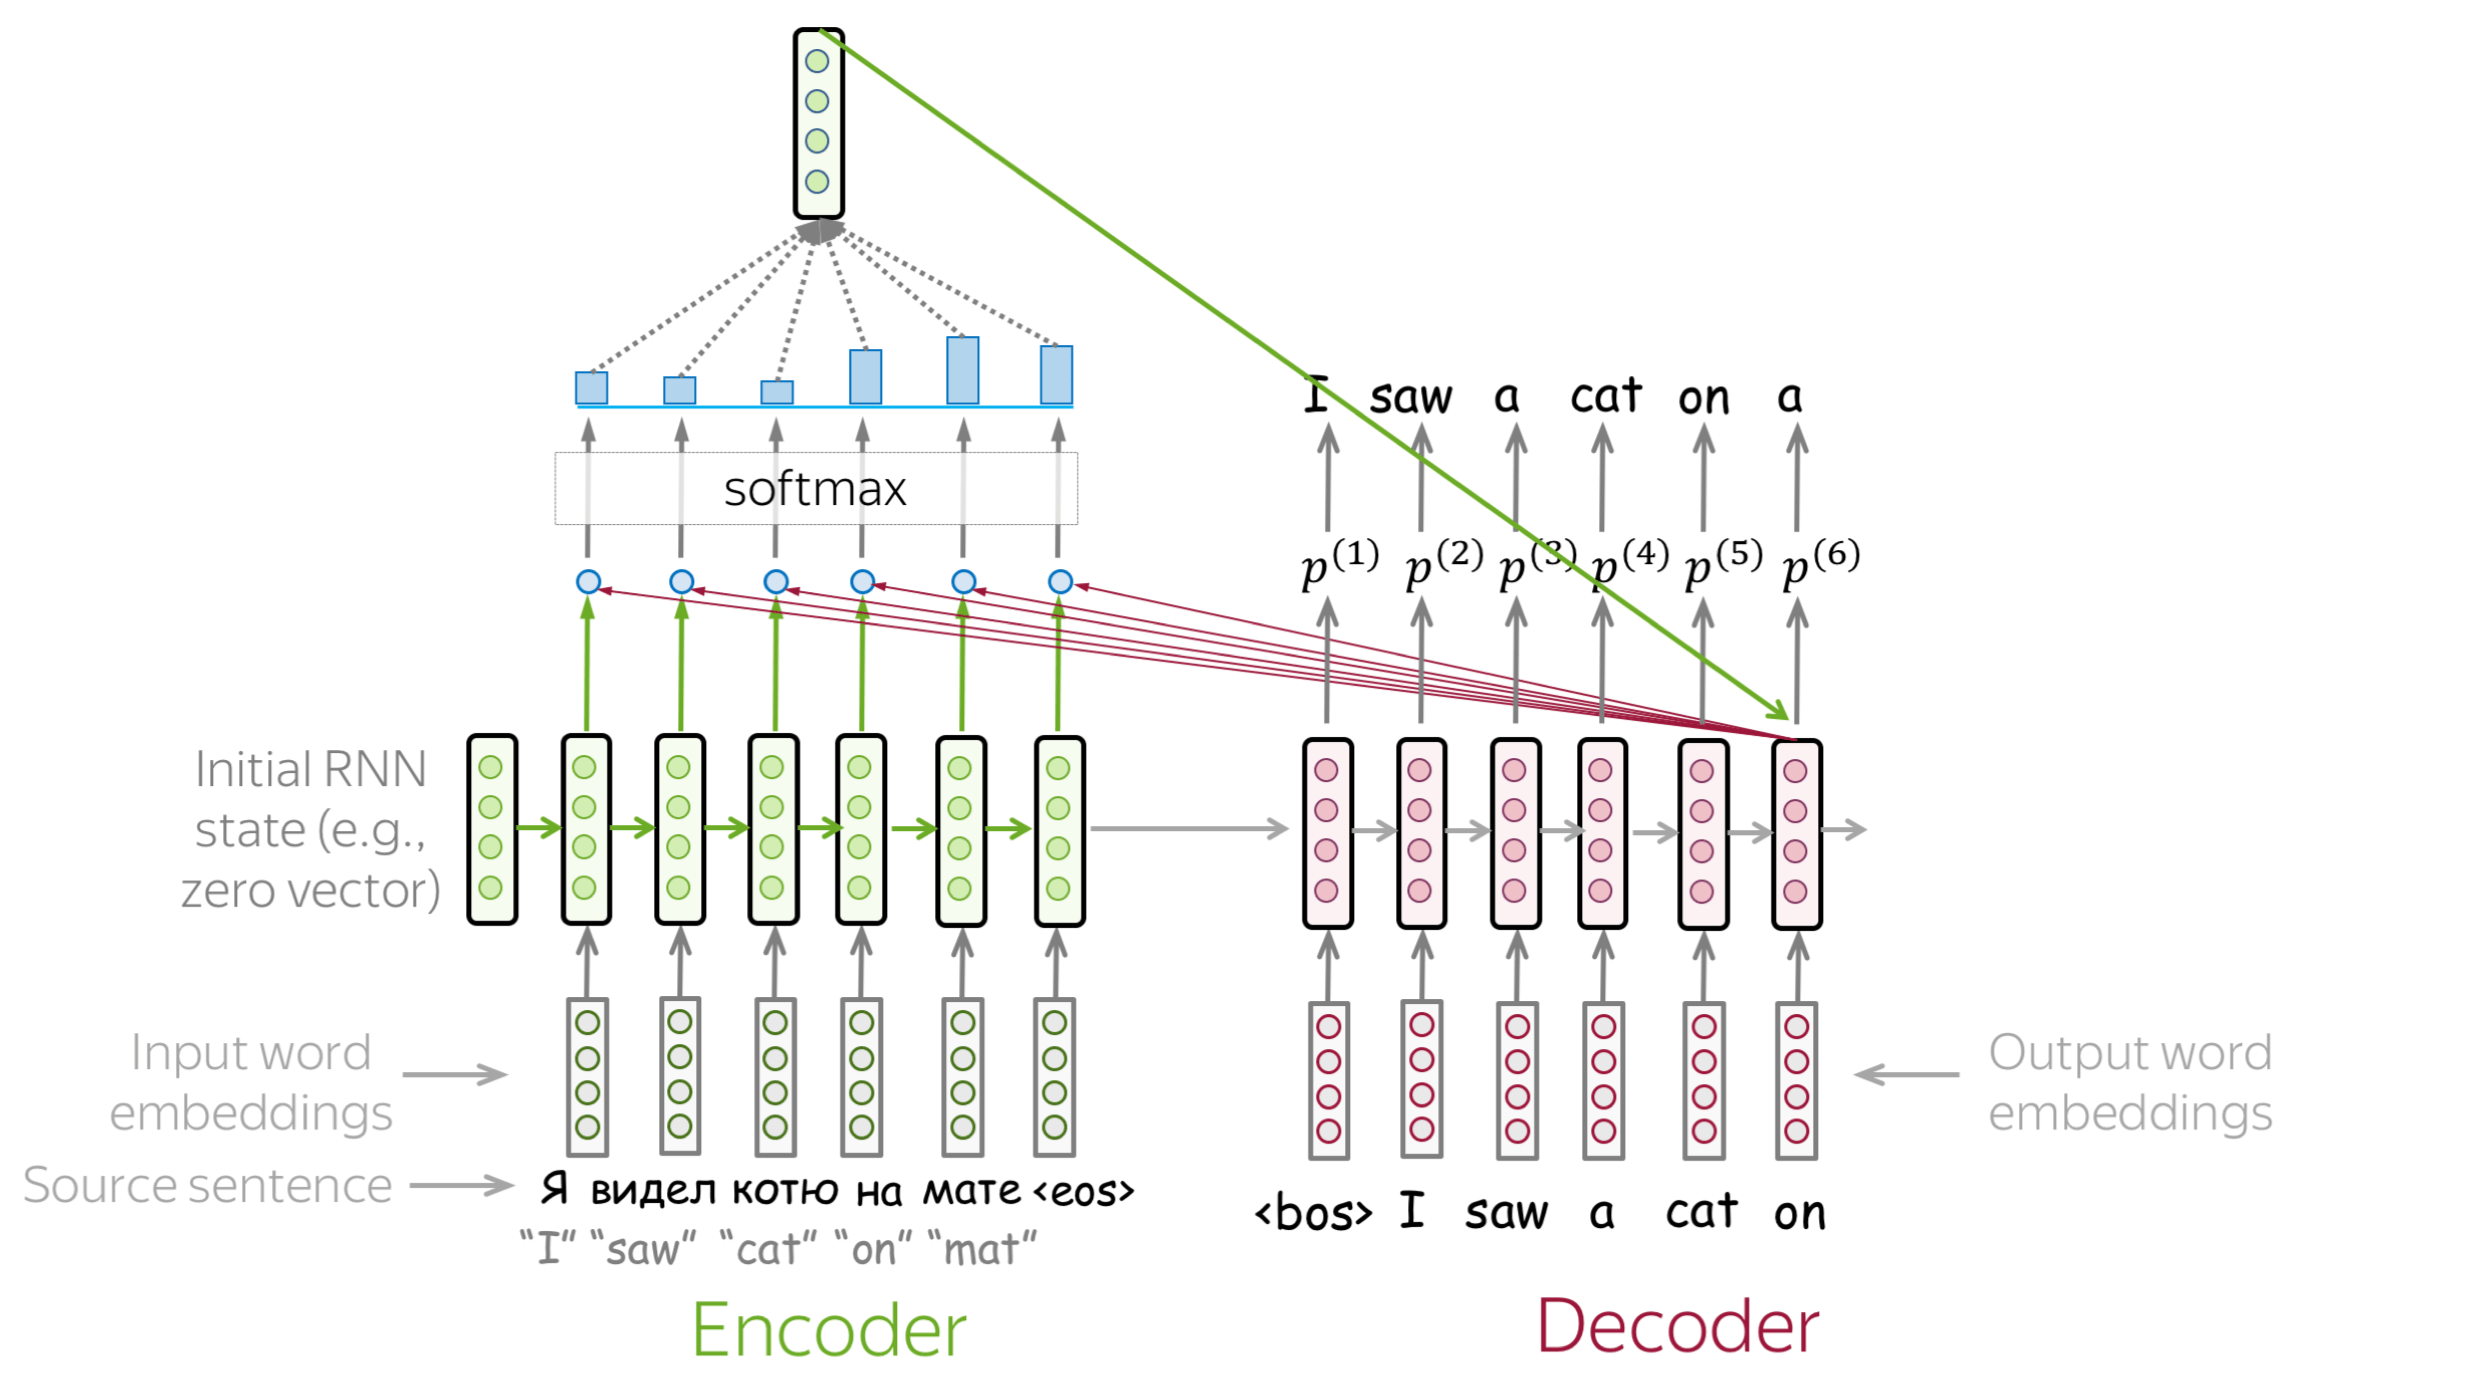

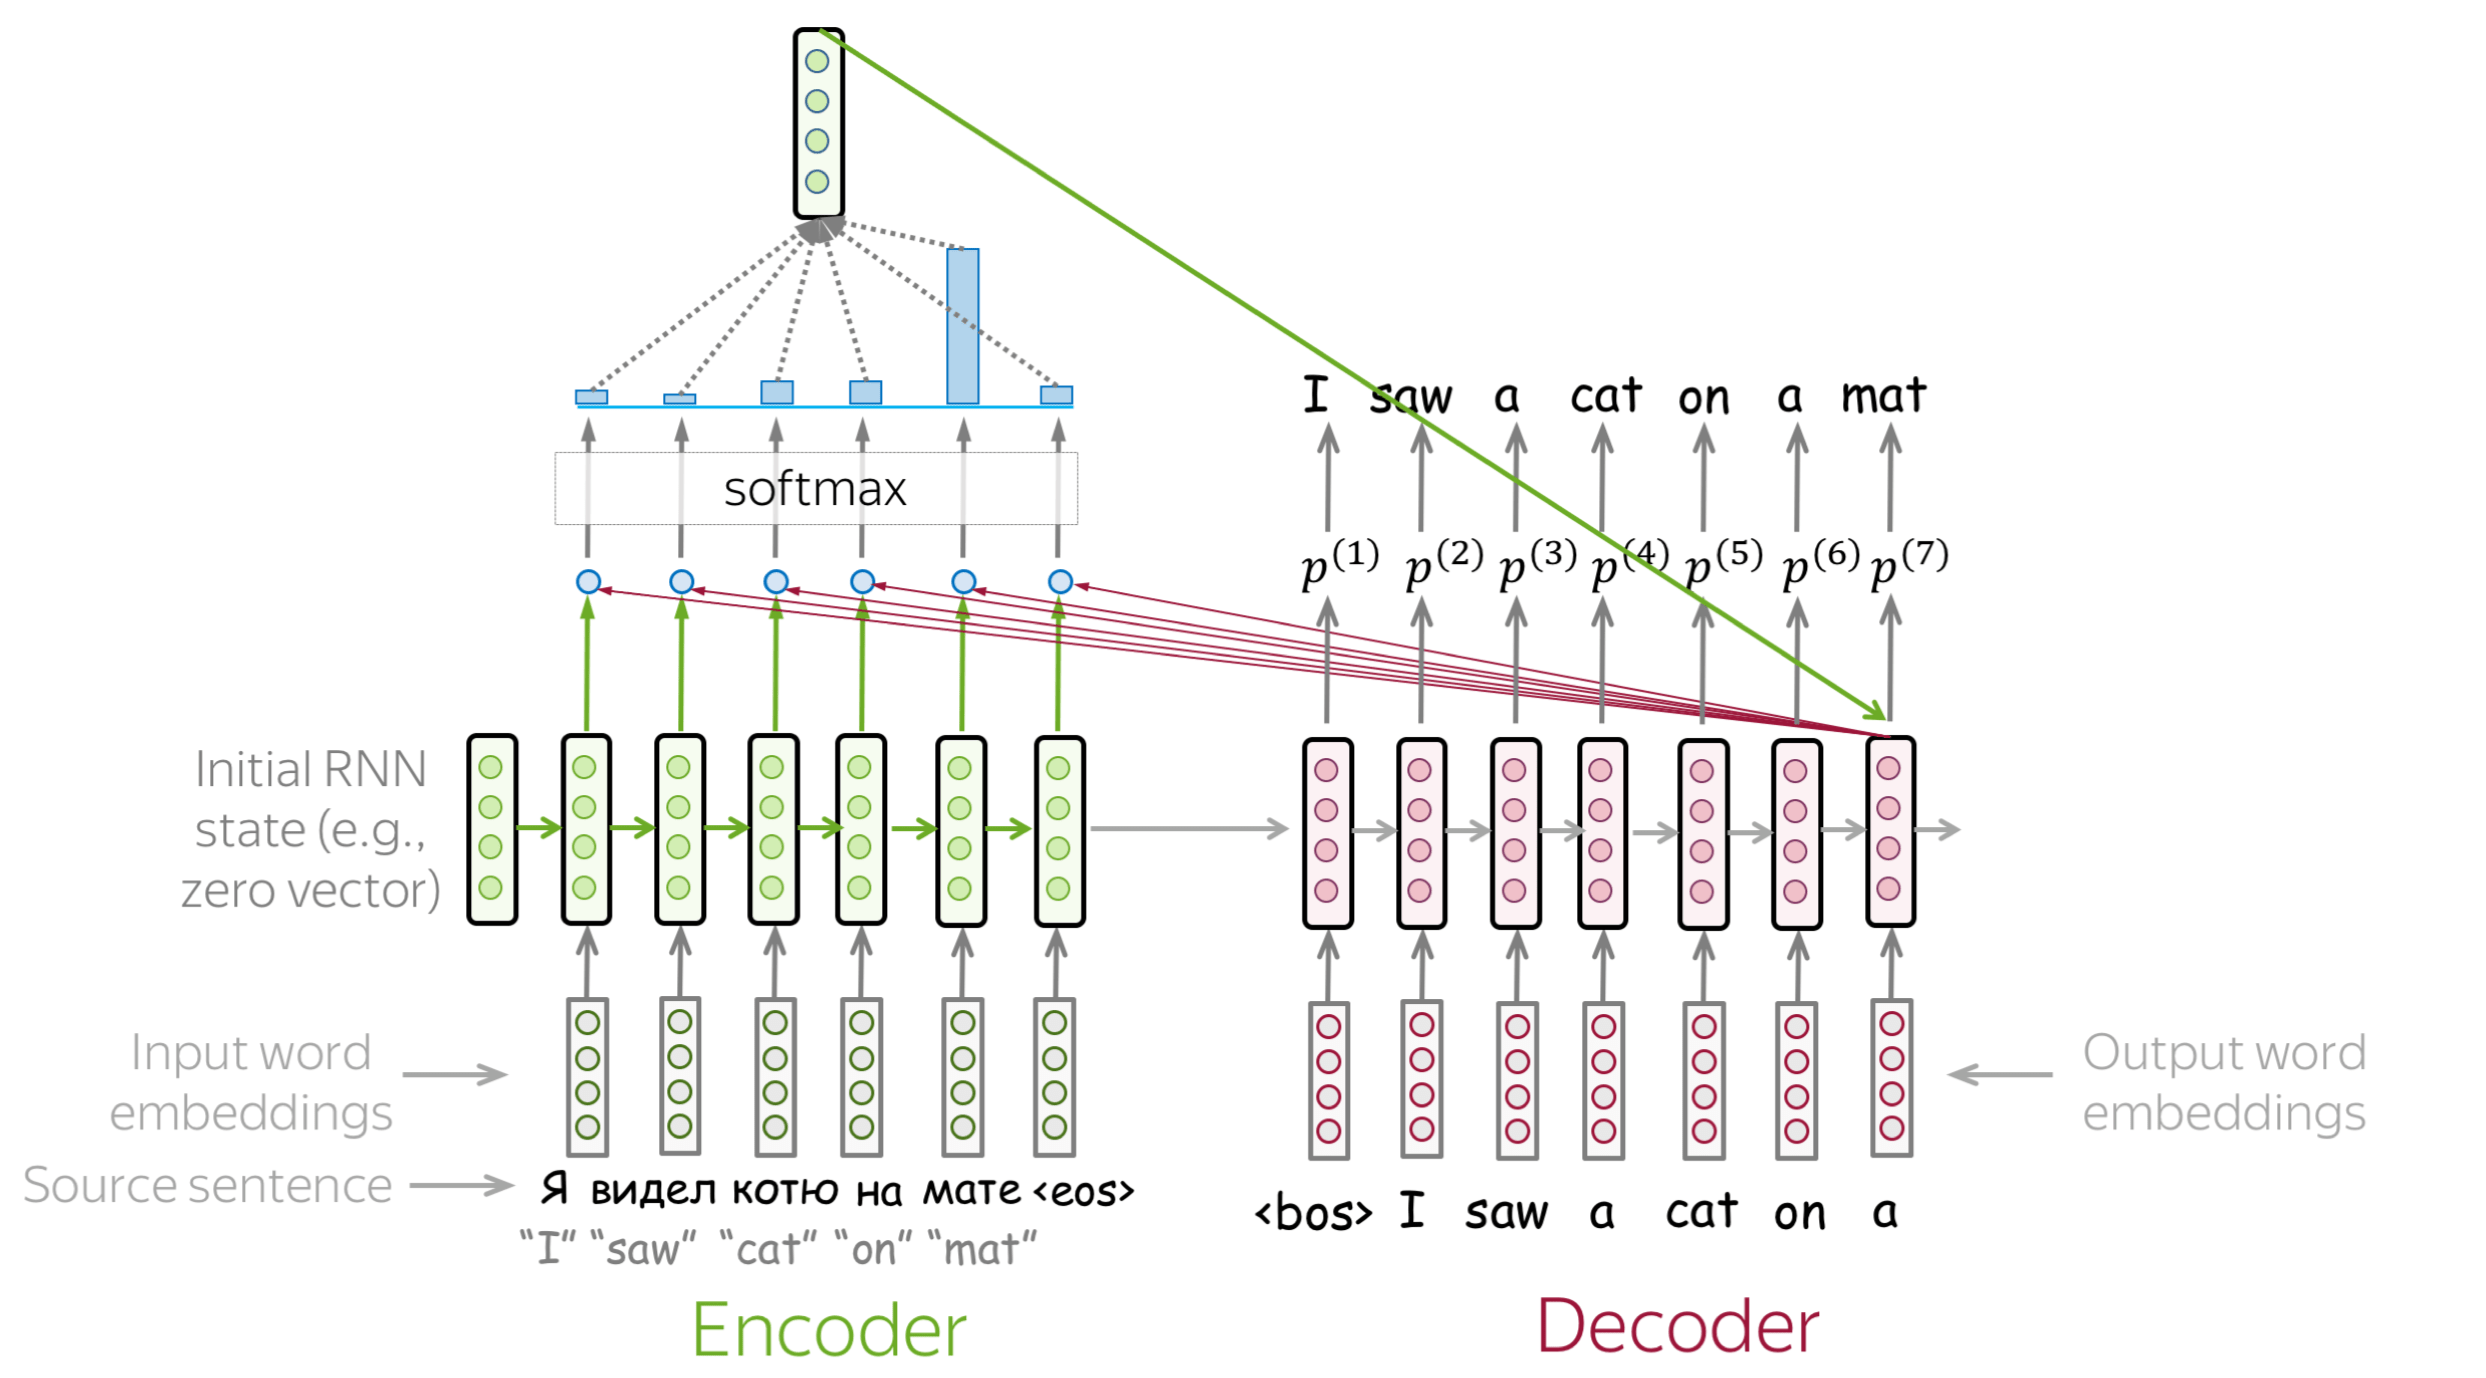

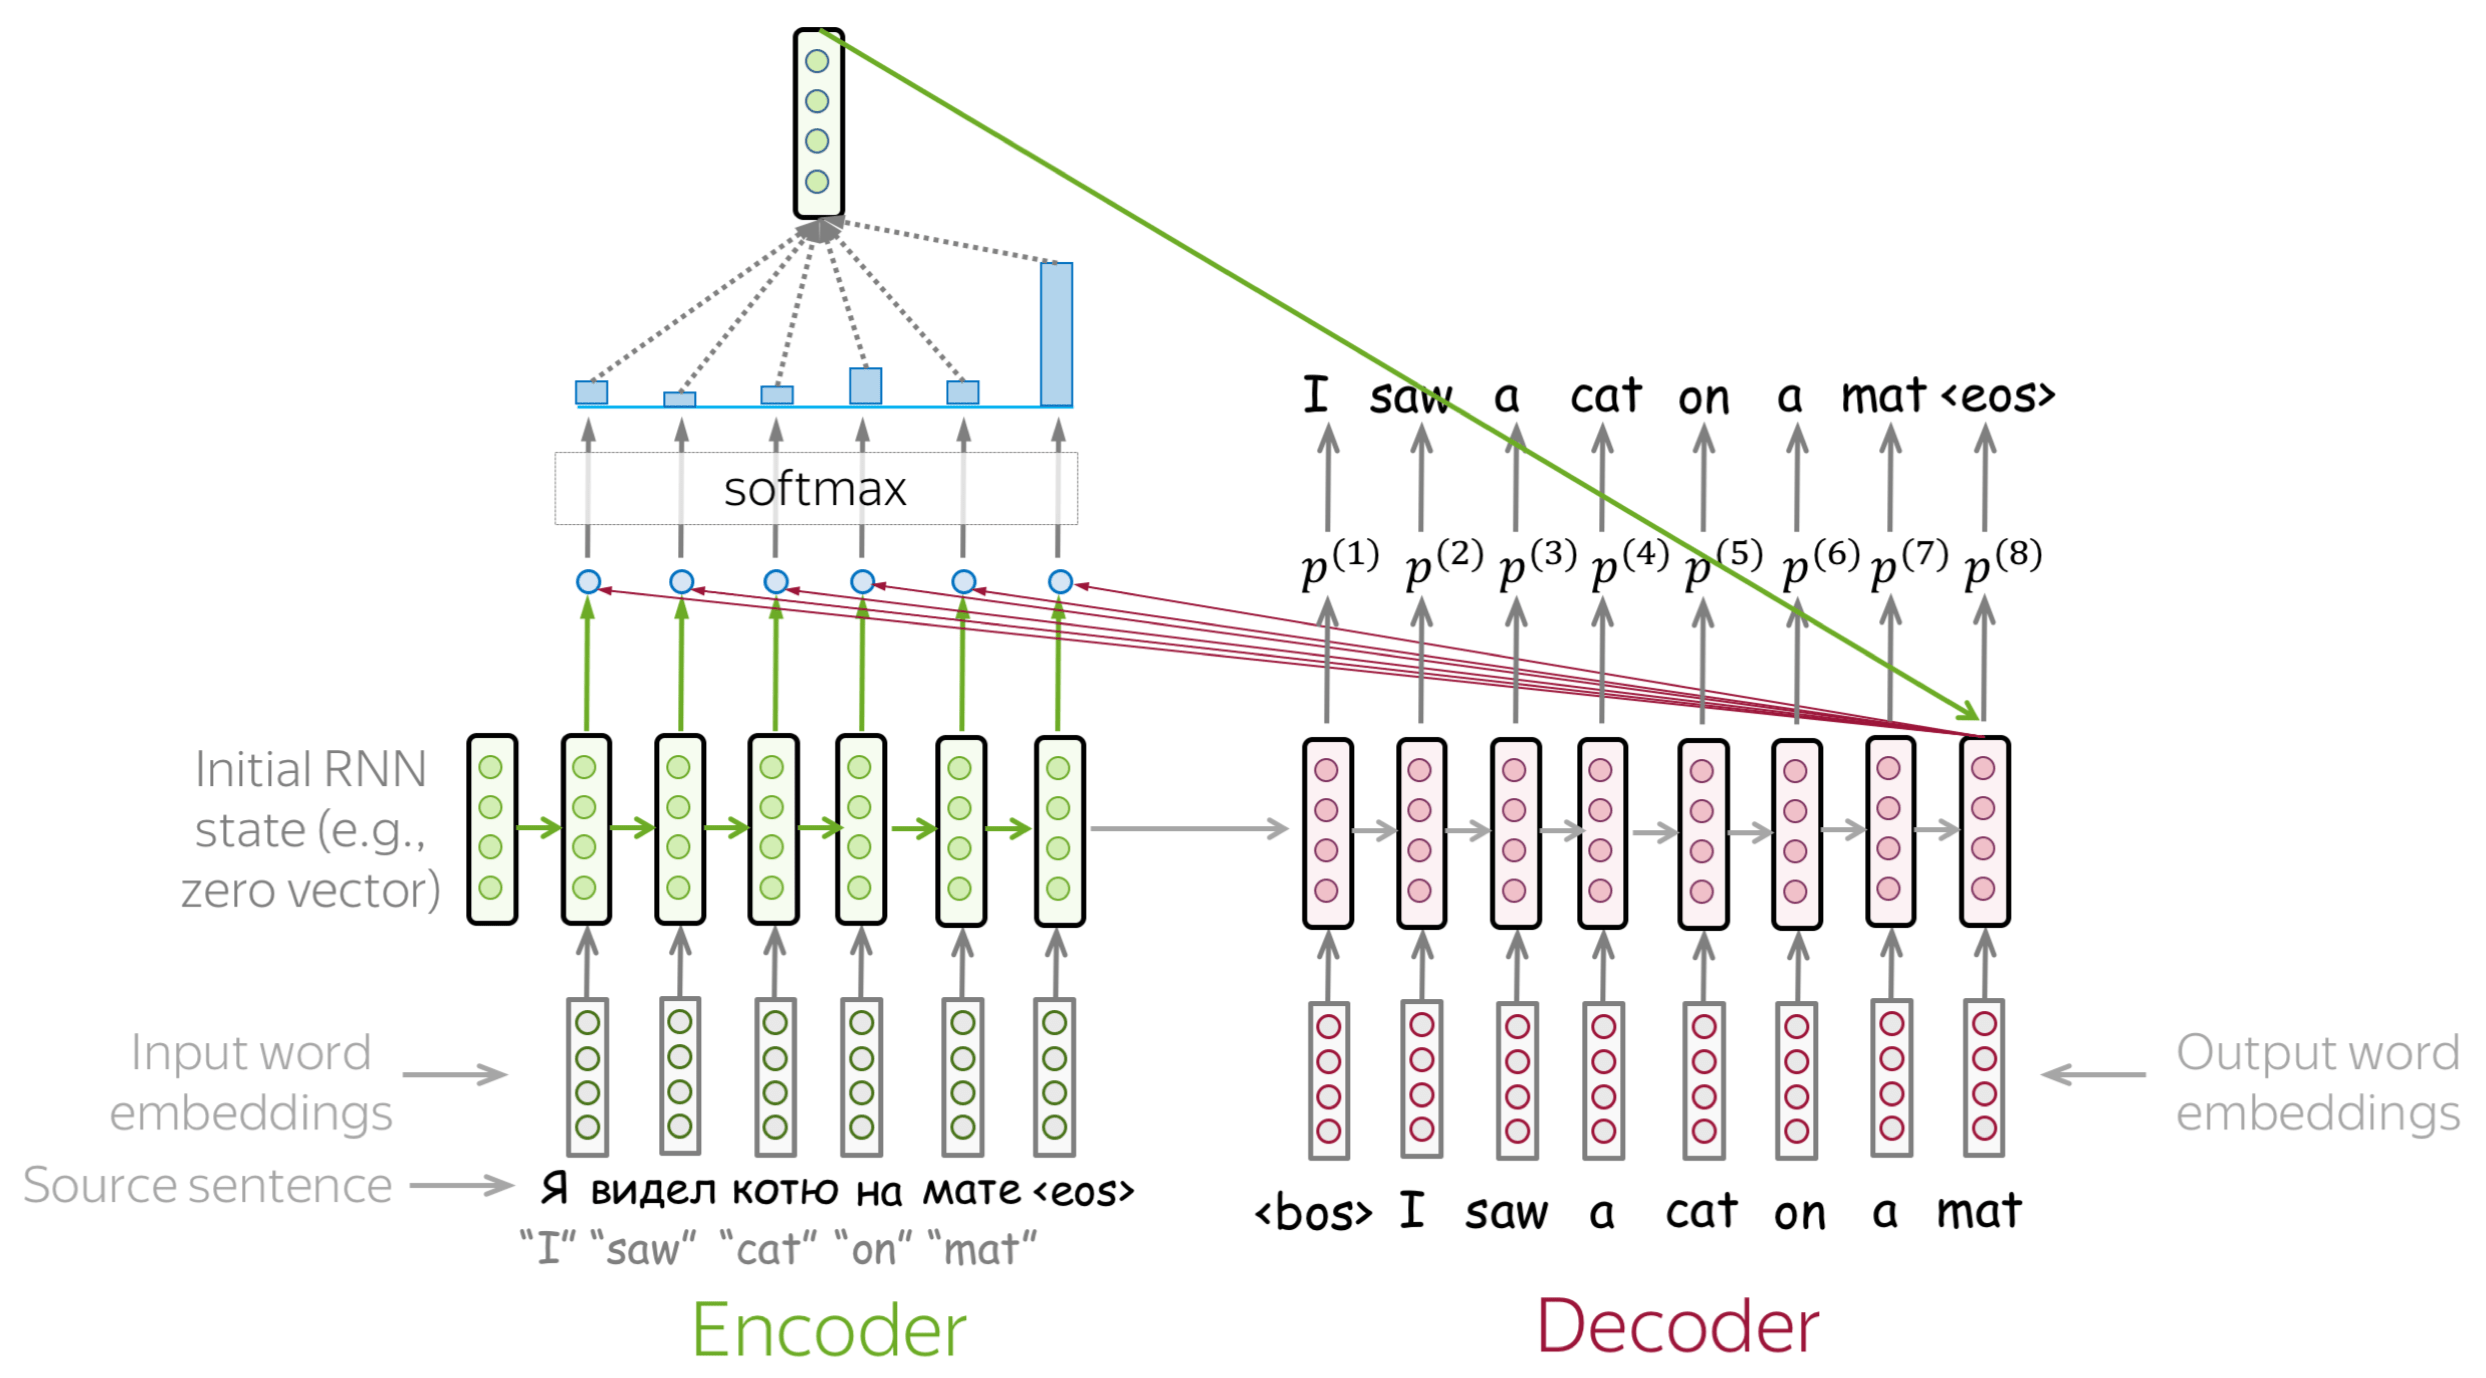


###**Как вычислить оценку внимания?**  

В общем алгоритме, описанном выше, мы не уточняли, как именно вычисляются оценки внимания. Вы можете использовать любую функцию, даже очень сложную. Однако, как правило, в этом нет необходимости — существуют несколько популярных и простых методов, которые работают достаточно хорошо.  



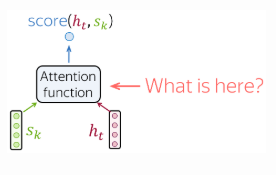

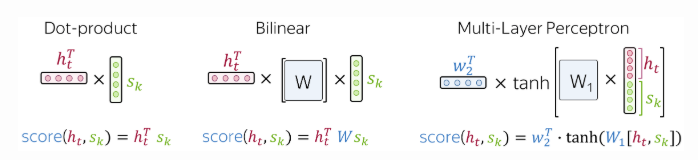



**Наиболее популярные методы вычисления оценок внимания:**  
- **Скалярное произведение (dot-product):** самый простой метод.  
- **Билинейная функция (также известна как "внимание Люонга"):** используется в статье *[Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025)*.  
- **Многослойный перцептрон (также известен как "внимание Бахданау"):** метод, предложенный в[ оригинальной статье о механизме внимания](https://arxiv.org/pdf/1409.0473.pdf).  




##**Варианты моделей: Бахданау и Люонг**  

Когда речь заходит о ранних моделях с механизмом внимания, чаще всего упоминаются следующие варианты:  
- **Внимание Бахданау:** предложено в статье *Neural Machine Translation by Jointly Learning to Align and Translate* авторства Дзмитрия Бахданау, Кюн Хён Чо и Йошуа Бенжио (эта работа впервые представила механизм внимания).  
- **Внимание Люонга:** описано в статье *Effective Approaches to Attention-based Neural Machine Translation* авторства Мин-Танга Люонга, Хиеу Фама и Кристофера Д. Мэннинга.  

Эти термины могут относиться как к функциям вычисления оценки внимания, так и к самим моделям, представленным в этих статьях. В этом разделе мы рассмотрим оба варианта моделей более подробно.  



### **Модель Бахданау**  

- **Энкодер:** двунаправленный  
  Для лучшего кодирования каждого слова источника энкодер использует два RNN: прямой и обратный, которые обрабатывают входные данные в противоположных направлениях. Для каждого токена состояния обоих RNN объединяются (конкатенируются).  

- **Оценка внимания:** многослойный перцептрон  
  Чтобы вычислить оценку внимания, применяется многослойный перцептрон (MLP) к состоянию энкодера и состоянию декодера.  

- **Применение внимания:** между шагами декодера  
  Механизм внимания используется между шагами декодера: состояние $h_{t-1}$ применяется для вычисления внимания и его выхода $c(t)$. Оба результата, $h_{t-1}$ и $c(t)$, передаются декодеру на шаге $t$.  



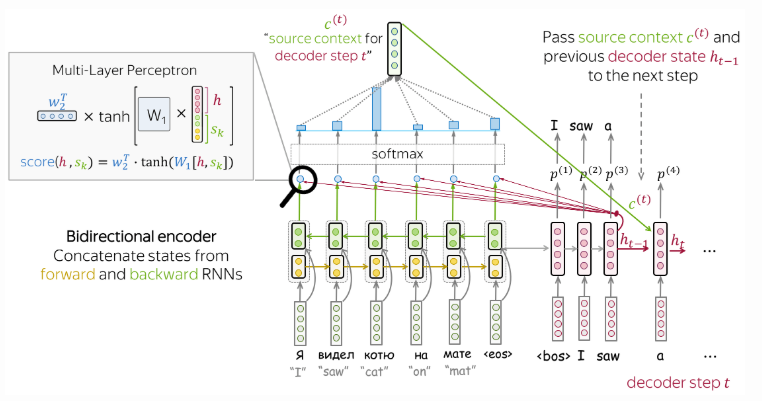